In [ ]:
!pip3 install pandas 
!pip3 install h5py 
!pip3 install tqdm 
!pip3 install torchinfo
!pip3 install matplotlib 
!pip3 install seaborn 
!pip3 install scikit-learn

   ---------------------------------------- 0.0/10.7 MB ? eta -:--:--
    --------------------------------------- 0.3/10.7 MB ? eta -:--:--
   -- ------------------------------------- 0.8/10.7 MB 2.4 MB/s eta 0:00:05
   ---- ----------------------------------- 1.3/10.7 MB 2.5 MB/s eta 0:00:04
   ------- -------------------------------- 2.1/10.7 MB 2.7 MB/s eta 0:00:04
   --------- ------------------------------ 2.6/10.7 MB 2.7 MB/s eta 0:00:03
   ----------- ---------------------------- 3.1/10.7 MB 2.7 MB/s eta 0:00:03
   -------------- ------------------------- 3.9/10.7 MB 2.8 MB/s eta 0:00:03
   ----------------- ---------------------- 4.7/10.7 MB 2.9 MB/s eta 0:00:03
   ------------------- -------------------- 5.2/10.7 MB 3.0 MB/s eta 0:00:02
   ---------------------- ----------------- 6.0/10.7 MB 3.0 MB/s eta 0:00:02
   ------------------------- -------------- 6.8/10.7 MB 3.0 MB/s eta 0:00:02
   --------------------------- ------------ 7.3/10.7 MB 3.1 MB/s eta 0:00:02
   ----------

In [1]:
import torch 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [45]:
import numpy as np
import pandas as pd
import h5py
import json
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler, autocast
from torchinfo import summary
import torch.utils.checkpoint as checkpoint
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm, trange
import seaborn as sns
import gc
import time
import warnings
from collections import deque
import psutil
import os

In [31]:
n_channels=2
batch_size = 512      # or 128, 256, 512, etc.
frame_size = 1024    # fixed by dataset (1024 I/Q samples per frame)
n_labels = 8
nf_train = int(batch_size * 0.7)
nf_valid = int(batch_size * 0.2)
nf_test  = batch_size - nf_train - nf_valid

In [32]:
def dataset_split(data,
                  modulations_classes,
                  modulations,
                  snrs,
                  target_modulations,
                  mode,
                  target_snrs,
                  train_proportion=0.7, # training 70 %
                  valid_proportion=0.2, # validation 20 %
                  test_proportion=0.1, # testing 10 % 
                  seed=48):
    np.random.seed(seed)
    X_output = []
    Y_output = []
    Z_output = []                                   

    target_modulation_indices = [modulations_classes.index(modu) for modu in target_modulations]

    for modu in target_modulation_indices:
        for snr in target_snrs:
            snr_modu_indices = np.where((modulations == modu) & (snrs == snr))[0]

            np.random.shuffle(snr_modu_indices)
            num_samples = len(snr_modu_indices)
            train_end = int(train_proportion * num_samples)
            valid_end = int((train_proportion + valid_proportion) * num_samples)

            if mode == 'train':
                indices = snr_modu_indices[:train_end]
            elif mode == 'valid':
                indices = snr_modu_indices[train_end:valid_end]
            elif mode == 'test':
                indices = snr_modu_indices[valid_end:]
            else:
                raise ValueError(f'unknown mode: {mode}. Valid modes are train, valid and test')

            X_output.append(data[np.sort(indices)])
            Y_output.append(modulations[np.sort(indices)])
            Z_output.append(snrs[np.sort(indices)])

    X_array = np.vstack(X_output)
    Y_array = np.concatenate(Y_output)
    Z_array = np.concatenate(Z_output)
    for index, value in enumerate(np.unique(np.copy(Y_array))):
        Y_array[Y_array == value] = index
    return X_array, Y_array, Z_array

In [74]:
class RadioML18Dataset(Dataset):
    def __init__(self, mode: str, seed=48,):
        super(RadioML18Dataset, self).__init__()

        # load data
        hdf5_file = h5py.File("C:\\workarea\\CNN model\\dataset\\radioml2018\\versions\\2\\GOLD_XYZ_OSC.0001_1024.hdf5", 'r') #Escaped backslashes 
        self.modulation_classes = json.load(open("C:\\workarea\\CNN model\\dataset\\radioml2018\\versions\\2\\classes-fixed.json", 'r'))
        self.X = hdf5_file['X']
        self.Y = np.argmax(hdf5_file['Y'], axis=1)
        self.Z = hdf5_file['Z'][:, 0]

        train_proportion=(10*26*nf_train)/self.X.shape[0]
        valid_proportion=(10*26*nf_valid)/self.X.shape[0]
        test_proportion=(10*26*nf_test)/self.X.shape[0]

        """target_modulations =['OOK', '4ASK', 'BPSK', 'QPSK', '8PSK',
        '16QAM', 'AM-SSB-SC', 'AM-DSB-SC', 'FM', 'GMSK','OQPSK']target
        modulation class and snr"""

        # in this line i could change it the target modulation
        self.target_modulations = [
                    'OOK', '4ASK', '8ASK', 'BPSK', 
                    'QPSK', '8PSK', '16PSK', '32PSK','16QAM','64QAM'
                ]

        self.target_snrs = np.unique(self.Z)

        self.X_data, self.Y_data, self.Z_data = dataset_split(
                                                                  data = self.X,
                                                                  modulations_classes = self.modulation_classes,
                                                                  modulations = self.Y,
                                                                  snrs = self.Z,
                                                                  mode = mode,
                                                                  train_proportion = train_proportion,
                                                                  valid_proportion = valid_proportion,
                                                                  test_proportion = test_proportion,
                                                                  target_modulations = self.target_modulations,
                                                                  target_snrs  = self.target_snrs,
                                                                  seed=48
                                                                 )

        # *** CRITICAL FIX: Apply I/Q swap correction for AMC compatibility ***
        print(f"🔧 Applying I/Q swap fix to {mode} dataset...")
        X_corrected = np.zeros_like(self.X_data)
        X_corrected[:, :, 0] = self.X_data[:, :, 1]  # I = original Q
        X_corrected[:, :, 1] = self.X_data[:, :, 0]  # Q = original I
        self.X_data = X_corrected
        print(f"✅ I/Q channels corrected for real-world compatibility")

        # store statistic of whole dataset (unchanged)
        self.num_data = self.X_data.shape[0]
        self.num_lbl = len(self.target_modulations)
        self.num_snr = self.target_snrs.shape[0]

    def __len__(self):
        return self.X_data.shape[0]

    def __getitem__(self, idx):
        x,y,z = self.X_data[idx], self.Y_data[idx], self.Z_data[idx]
        x,y,z = torch.Tensor(x).transpose(0, 1) , y , z
        return x,y,z

In [75]:
ds = RadioML18Dataset(mode='test')
data_len = ds.num_data
n_labels=ds.num_lbl
n_snrs = ds.num_snr
frame_size=ds.X.shape[1]

print(data_len)
print(n_labels)
print(n_snrs)
print(frame_size)
del ds

🔧 Applying I/Q swap fix to test dataset...
✅ I/Q channels corrected for real-world compatibility
1015300
10
26
1024


In [35]:
dataset = RadioML18Dataset(mode='train')

# Print all modulation classes
print("All Modulation Classes:", dataset.modulation_classes)


🔧 Applying I/Q swap fix to train dataset...
✅ I/Q channels corrected for real-world compatibility
All Modulation Classes: ['OOK', '4ASK', '8ASK', 'BPSK', 'QPSK', '8PSK', '16PSK', '32PSK', '16APSK', '32APSK', '64APSK', '128APSK', '16QAM', '32QAM', '64QAM', '128QAM', '256QAM', 'AM-SSB-WC', 'AM-SSB-SC', 'AM-DSB-WC', 'AM-DSB-SC', 'FM', 'GMSK', 'OQPSK']


In [36]:
import time
st = time.time()
train_dl = DataLoader(dataset=RadioML18Dataset(mode='train'),batch_size = 256, shuffle = True, drop_last = True)
valid_dl = DataLoader(dataset=RadioML18Dataset(mode='valid'),batch_size = 128, shuffle = True, drop_last = False)
test_dl = DataLoader(dataset=RadioML18Dataset(mode='test'), batch_size = 128, shuffle = True, drop_last = False)
et = time.time()
elapsed_time = et - st
print(f'Execution time : {elapsed_time} second')

🔧 Applying I/Q swap fix to train dataset...
✅ I/Q channels corrected for real-world compatibility
🔧 Applying I/Q swap fix to valid dataset...
✅ I/Q channels corrected for real-world compatibility
🔧 Applying I/Q swap fix to test dataset...
✅ I/Q channels corrected for real-world compatibility
Execution time : 22.89482808113098 second


In [37]:
class ImprovedCNN_Block(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_rate=0.4, use_residual = True):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2),
            nn.Dropout(dropout_rate)
        )

    def forward(self, x):
        return self.block(x)

class ImprovedCNN_NET(nn.Module):
    def __init__(self, n_labels, dropout_rate=0.4):
        super().__init__()

        self.backbone = nn.Sequential(
            ImprovedCNN_Block(2, 32, dropout_rate=0.2),
            ImprovedCNN_Block(32, 64, dropout_rate=0.3),
            ImprovedCNN_Block(64, 128, dropout_rate=0.3),
            nn.AdaptiveAvgPool1d(16)
        )

        # Enhanced classifier for 19-class problem
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate * 0.75),

            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate * 0.5),

            nn.Linear(128, n_labels)  # This will be 19 for full dataset
        )

    def forward(self, x):
        x = self.backbone(x)
        return self.classifier(x)

def create_improved_model(n_labels, dropout_rate=0.4):
    """Create improved CNN model - now works for any number of classes"""
    return ImprovedCNN_NET(n_labels, dropout_rate)

In [38]:
class EarlyStopping:
    def __init__(self, patience=15, min_delta=0.001, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_loss = float('inf')
        self.counter = 0
        self.best_weights = None

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            if self.restore_best_weights:
                self.best_weights = model.state_dict().copy()
        else:
            self.counter += 1

        if self.counter >= self.patience:
            if self.restore_best_weights and self.best_weights is not None:
                model.load_state_dict(self.best_weights)
            return True
        return False

In [39]:
model =ImprovedCNN_NET(n_labels).to('cuda')

# Safer: create explicit dummy input
dummy_input = torch.randn(1, n_channels, frame_size).to('cuda')

summary(model, input_data=dummy_input)

Layer (type:depth-idx)                   Output Shape              Param #
ImprovedCNN_NET                          [1, 8]                    --
├─Sequential: 1-1                        [1, 128, 16]              --
│    └─ImprovedCNN_Block: 2-1            [1, 32, 512]              --
│    │    └─Sequential: 3-1              [1, 32, 512]              3,456
│    └─ImprovedCNN_Block: 2-2            [1, 64, 256]              --
│    │    └─Sequential: 3-2              [1, 64, 256]              18,816
│    └─ImprovedCNN_Block: 2-3            [1, 128, 128]             --
│    │    └─Sequential: 3-3              [1, 128, 128]             74,496
│    └─AdaptiveAvgPool1d: 2-4            [1, 128, 16]              --
├─Sequential: 1-2                        [1, 8]                    --
│    └─Flatten: 2-5                      [1, 2048]                 --
│    └─Linear: 2-6                       [1, 512]                  1,049,088
│    └─BatchNorm1d: 2-7                  [1, 512]                  

In [40]:
# ============================================================================
# 1. IMPROVED TRAINING FUNCTION
# ============================================================================

def train_model(model, train_dl=train_dl, valid_dl=valid_dl, verbose=True, device='cuda', num_epoch=200,
                accumulation_steps=1, use_amp=True, memory_cleanup_freq=10):
    """
    GPU memory-optimized training function for Google Colab Pro

    Args:
        model: Neural network model
        train_dl: Training dataloader
        valid_dl: Validation dataloader
        verbose: Print training progress
        device: Device to train on
        num_epoch: Maximum number of epochs
        accumulation_steps: Gradient accumulation steps (effective batch size = batch_size * accumulation_steps)
        use_amp: Use Automatic Mixed Precision (saves ~40-50% GPU memory)
        memory_cleanup_freq: How often to clean GPU memory (every N epochs)
    """

    # GPU memory check and optimization
    if device == 'cuda':
        print(f"GPU: {torch.cuda.get_device_name()}")
        print(f"Initial GPU memory: {torch.cuda.memory_allocated()/1024**3:.2f}GB / {torch.cuda.memory_reserved()/1024**3:.2f}GB")
        torch.cuda.empty_cache()

    model.to(device)

    # Use deque for memory-efficient history storage (only keep recent values)
    history_size = min(num_epoch, 1000)  # Limit history to prevent memory issues
    train_loss_history = deque(maxlen=history_size)
    train_acc_history = deque(maxlen=history_size)
    val_loss_history = deque(maxlen=history_size)
    val_acc_history = deque(maxlen=history_size)

    # Improved optimizer with memory-efficient settings
    lr = 1e-4
    optimizer = optim.AdamW(
        model.parameters(),
        lr=lr,
        weight_decay=1e-4,
        eps=1e-8,  # Slightly larger eps for numerical stability in mixed precision
        amsgrad=False  # Disable amsgrad to save memory
    )

    # Learning rate scheduler
    lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=10,
        #verbose=True,
        min_lr=1e-6
    )

    # setup the new path for the model 
    output_dir = r"C:\workarea\CNN model\model"
    os.makedirs(output_dir, exist_ok=True)
    
    # Label smoothing for better generalization
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    # Mixed precision training setup
    scaler = GradScaler() if use_amp else None

    # Early stopping variables
    best_val_loss = float('inf')
    best_val_acc = 0.0
    patience = 20
    patience_counter = 0
    best_model_path = os.path.join(output_dir, 'best_model.pth')  # Save to disk instead of memory

    actual_epochs = 0

    try:
        for epoch in trange(num_epoch, desc='Training'):
            actual_epochs = epoch + 1

            # Memory cleanup every N epochs
            if epoch % memory_cleanup_freq == 0 and epoch > 0:
                gc.collect()
                if device == 'cuda':
                    torch.cuda.empty_cache()
                    if verbose:
                        tqdm.write(f"GPU memory after cleanup: {torch.cuda.memory_allocated()/1024**3:.2f}GB")

            # ----- Training Phase -----
            model.train()
            total_train_loss, total_train_correct, total_train_samples = 0.0, 0, 0

            # Reset gradients outside the loop
            optimizer.zero_grad()

            for batch_idx, (x, y, _) in enumerate(train_dl):
                x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)

                # Gradient accumulation context
                # FIXED: Correctly use autocast with device_type and enabled
                with autocast(enabled=use_amp):
                    # Optional: Add noise augmentation (but less frequently to save memory)
                    if torch.rand(1).item() < 0.2:  # Reduced from 30% to 20%
                        noise = torch.randn_like(x) * 0.05
                        x = x + noise

                    logits = model(x)
                    loss = criterion(logits, y)

                    # Scale loss for gradient accumulation
                    loss = loss / accumulation_steps

                # Backward pass with mixed precision
                if use_amp:
                    scaler.scale(loss).backward()
                else:
                    loss.backward()

                # Update weights every accumulation_steps
                if (batch_idx + 1) % accumulation_steps == 0:
                    if use_amp:
                        scaler.unscale_(optimizer)
                        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                        scaler.step(optimizer)
                        scaler.update()
                    else:
                        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                        optimizer.step()

                    optimizer.zero_grad()

                # Accumulate statistics (scale back the loss)
                with torch.no_grad():
                    total_train_loss += (loss.item() * accumulation_steps) * x.size(0)
                    total_train_correct += (logits.argmax(dim=1) == y).sum().item()
                    total_train_samples += x.size(0)

                # Clear intermediate tensors
                del x, y, logits, loss

            # Handle remaining gradients
            if (len(train_dl) % accumulation_steps) != 0:
                if use_amp:
                    scaler.unscale_(optimizer)
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                    scaler.step(optimizer)
                    scaler.update()
                else:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                    optimizer.step()
                optimizer.zero_grad()

            epoch_train_loss = total_train_loss / total_train_samples
            epoch_train_acc = total_train_correct / total_train_samples

            train_loss_history.append(epoch_train_loss)
            train_acc_history.append(epoch_train_acc)

            # ----- Validation Phase -----
            model.eval()
            total_val_loss, total_val_correct, total_val_samples = 0.0, 0, 0

            with torch.no_grad():
                for x, y, _ in valid_dl:
                    x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)

                    # FIXED: Correctly use autocast with device_type and enabled
                    with autocast(enabled=use_amp):
                        logits = model(x)
                        loss = criterion(logits, y)

                    total_val_loss += loss.item() * x.size(0)
                    total_val_correct += (logits.argmax(dim=1) == y).sum().item()
                    total_val_samples += x.size(0)

                    # Clear tensors immediately
                    del x, y, logits, loss

            epoch_val_loss = total_val_loss / total_val_samples
            epoch_val_acc = total_val_correct / total_val_samples

            val_loss_history.append(epoch_val_loss)
            val_acc_history.append(epoch_val_acc)

            # Update learning rate
            lr_scheduler.step(epoch_val_loss)

            # Early stopping logic with disk-based model saving
            if epoch_val_loss < best_val_loss - 0.001:
                best_val_loss = epoch_val_loss
                best_val_acc = epoch_val_acc
                # Save best model to disk instead of keeping in memory
                torch.save(model.state_dict(), 'best_model.pth')
                patience_counter = 0
            else:
                patience_counter += 1

            # Check if we should stop early
            if patience_counter >= patience:
                if verbose:
                    tqdm.write(f"\nEarly stopping triggered at epoch {epoch+1}")
                    tqdm.write(f"Best validation loss: {best_val_loss:.4f}, Best validation acc: {best_val_acc:.4f}")

                # Load best model from disk
                try:
                    model.load_state_dict(torch.load(best_model_path, map_location=device))
                except:
                    tqdm.write("Warning: Could not load best model state")
                break

            # Memory-conscious verbose output
            if verbose:
                show_progress = (
                    (epoch + 1) % 10 == 0 or
                    epoch < 10 or
                    epoch_val_acc > best_val_acc or
                    patience_counter == 0
                )

                if show_progress:
                    current_lr = optimizer.param_groups[0]['lr']
                    tqdm.write(f"Epoch {epoch+1:03d} | Train Loss: {epoch_train_loss:.4f}, Acc: {epoch_train_acc:.4f}")
                    tqdm.write(f"            | Val   Loss: {epoch_val_loss:.4f}, Acc: {epoch_val_acc:.4f}")
                    tqdm.write(f"            | LR: {current_lr:.6f}, Patience: {patience_counter}/{patience}")

                    if device == 'cuda':
                        tqdm.write(f"            | GPU Memory: {torch.cuda.memory_allocated()/1024**3:.2f}GB")

                    if epoch_val_acc > best_val_acc:
                        tqdm.write(f"            | *** New best validation accuracy! ***")

            # Force memory cleanup every few epochs
            if epoch % 5 == 0:
                gc.collect()

    except RuntimeError as e:
        if "out of memory" in str(e):
            print(f"\nGPU out of memory error at epoch {epoch+1}")
            print("Try reducing batch size, enabling gradient accumulation, or using mixed precision")
            print(f"Current GPU memory: {torch.cuda.memory_allocated()/1024**3:.2f}GB")

            # Emergency cleanup
            gc.collect()
            torch.cuda.empty_cache()

        raise e

    finally:
        # Final cleanup
        gc.collect()
        if device == 'cuda':
            torch.cuda.empty_cache()

    # Convert deque to lists for compatibility
    train_history = {
        'train_loss': list(train_loss_history),
        'train_acc': list(train_acc_history),
        'val_loss': list(val_loss_history),
        'val_acc': list(val_acc_history),
        'best_val_loss': best_val_loss,
        'best_val_acc': best_val_acc,
        'epochs_trained': actual_epochs
    }

    if verbose:
        print(f"\nTraining completed!")
        print(f"Epochs trained: {actual_epochs}")
        print(f"Final validation accuracy: {val_acc_history[-1]:.4f}")
        print(f"Best validation accuracy: {best_val_acc:.4f}")
        if device == 'cuda':
            print(f"Final GPU memory: {torch.cuda.memory_allocated()/1024**3:.2f}GB")

    return model, train_history


def get_memory_usage():
    """Utility function to check current GPU memory usage"""
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / 1024**3
        reserved = torch.cuda.memory_reserved() / 1024**3
        print(f"GPU Memory - Allocated: {allocated:.2f}GB, Reserved: {reserved:.2f}GB")
        return allocated, reserved
    return 0, 0


def optimize_dataloader_for_gpu(dataset, batch_size=512, num_workers=2):
    """
    Create memory-optimized dataloader for Colab Pro
    """
    return torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,  # Reduced for Colab
        pin_memory=True,  # Faster GPU transfer
        persistent_workers=True if num_workers > 0 else False,
        prefetch_factor=2,  # Reduced prefetch
        drop_last=True  # Ensures consistent batch sizes
    )

In [41]:
# ============================================================================
# 2. IMPROVED MODEL ARCHITECTURE
# ============================================================================

def create_improved_model(n_labels, dropout_rate=0.4):
    """
    Create an improved CNN model with better regularization
    """
    class ImprovedCNN_Block(nn.Module):
        def __init__(self, in_channels, out_channels, dropout_rate=0.3):
            super().__init__()
            self.block = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm1d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm1d(out_channels),
                nn.ReLU(inplace=True),
                nn.MaxPool1d(kernel_size=2),
                nn.Dropout(dropout_rate)
            )

        def forward(self, x):
            return self.block(x)

    class ImprovedCNN_NET(nn.Module):
        def __init__(self, n_labels, dropout_rate=0.4):
            super().__init__()

            self.backbone = nn.Sequential(
                ImprovedCNN_Block(2, 32, dropout_rate=0.2),
                ImprovedCNN_Block(32, 64, dropout_rate=0.3),
                ImprovedCNN_Block(64, 128, dropout_rate=0.3),
                nn.AdaptiveAvgPool1d(16)
            )

            self.classifier = nn.Sequential(
                nn.Flatten(),
                nn.Linear(128 * 16, 512),
                nn.BatchNorm1d(512),
                nn.ReLU(inplace=True),
                nn.Dropout(dropout_rate),

                nn.Linear(512, 256),
                nn.BatchNorm1d(256),
                nn.ReLU(inplace=True),
                nn.Dropout(dropout_rate * 0.75),

                nn.Linear(256, 128),
                nn.ReLU(inplace=True),
                nn.Dropout(dropout_rate * 0.5),

                nn.Linear(128, n_labels)
            )

        def forward(self, x):
            x = self.backbone(x)
            return self.classifier(x)

    return ImprovedCNN_NET(n_labels, dropout_rate)

In [42]:
# ============================================================================
# 3. IMPROVED TESTING AND ANALYSIS FUNCTIONS
# ============================================================================

def test_model_with_improved_plots(model, device='cuda'):
    """
    Enhanced testing function with better memory management and error handling
    """
    model.eval()
    Y_pred_ = []  # Predictions
    Y_true_ = []  # Ground truth
    Z_snr_ = []   # SNR values

    # FIXED: Use actual test dataset instead of train
    test_dataset = RadioML18Dataset(mode='test')
    test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False, drop_last=False)

    target_classes = test_dataset.target_modulations
    target_snrs = test_dataset.target_snrs
    modulation_classes = test_dataset.modulation_classes

    # Add debug
    print(f"Target modulations: {target_classes}")
    print(f"Target SNRs: {target_snrs}")
    print(f"Test dataset size: {len(test_dataset)}")

    # Initialize accuracy stats DataFrame
    accuracy_stats = pd.DataFrame(
        0.0,
        index=target_classes,
        columns=target_snrs.astype('str'))

    # Get predictions with tqdm progress bar
    test_progress = tqdm(test_loader, desc="Testing model", leave=True)

    with torch.no_grad():
        for batch_idx, (x, y, z) in enumerate(test_progress):
            # Move tensors to specified device
            x = x.to(device)
            y = y.to(device)
            z = z.to(device)

            # Get model predictions on device
            logits = model(x)
            y_pred = torch.argmax(logits, dim=-1)

            # Store results
            Y_pred_.append(y_pred.cpu())  # Move back to CPU for storage
            Y_true_.append(y.cpu())
            Z_snr_.append(z.cpu())

            # Update progress bar
            if batch_idx % 10 == 0:
                current_acc = (y_pred == y).float().mean().item()
                test_progress.set_postfix({"batch_acc": f"{current_acc:.3f}"})

            # Free up memory
            del x, y, z, logits, y_pred
            if device == 'cuda':
                torch.cuda.empty_cache()

    # Convert to numpy for easier processing
    Y_pred = torch.cat(Y_pred_).numpy()
    Y_true = torch.cat(Y_true_).numpy()
    Z_snr = torch.cat(Z_snr_).numpy()

    # Clear lists to free memory
    del Y_pred_, Y_true_, Z_snr_

    # Calculate overall accuracy
    correct_preds = (Y_pred == Y_true).sum()
    total_samples = len(Y_true)
    total_accuracy = round(correct_preds * 100 / total_samples, 2)
    print(f'Overall test accuracy: {total_accuracy}%')

    # Count samples for each modulation type
    mod_counts = {}
    for mod_idx, mod_name in enumerate(target_classes):
        count = np.sum(Y_true == mod_idx)
        mod_counts[mod_name] = count
        print(f"Modulation {mod_name}: {count} test samples")

    # Calculate accuracy per modulation and SNR with progress bar
    mod_snr_progress = tqdm(list(enumerate(target_classes)),
                           desc="Calculating per-modulation accuracies",
                           leave=True)

    for mod_idx, mod_name in mod_snr_progress:
        mod_snr_progress.set_postfix({"modulation": mod_name})
        for snr_idx, snr in enumerate(target_snrs):
            snr_str = str(snr)

            mask = (Y_true == mod_idx) & (Z_snr == snr)
            total_samples = mask.sum()
            if total_samples > 0:
                correct_samples = ((Y_pred == Y_true) & mask).sum()
                accuracy = (correct_samples * 100 / total_samples)
                accuracy_stats.loc[mod_name, snr_str] = round(accuracy, 2)
            else:
                accuracy_stats.loc[mod_name, snr_str] = np.nan
                print(f"Warning: no samples for {mod_name} at SNR = {snr}")

    return accuracy_stats, mod_counts, Y_true, Y_pred, target_classes

def plot_confusion_matrix(Y_true, Y_pred, target_classes, save_name='confusion_matrix'):
    """
    Plot confusion matrix for better understanding of misclassifications
    """
    cm = confusion_matrix(Y_true, Y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_classes,
                yticklabels=target_classes)
    plt.title('Confusion Matrix - Signal Modulation Classification')
    plt.xlabel('Predicted Modulation')
    plt.ylabel('True Modulation')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(f'{save_name}.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Print classification report
    print("\nDetailed Classification Report:")
    print(classification_report(Y_true, Y_pred, target_names=target_classes))

def plot_improved_test_accuracy(model, device='cuda', save_prefix='model'):
    """
    Enhanced plotting function with confusion matrix and better analysis
    """
    accuracy_df, mod_counts, Y_true, Y_pred, target_classes = test_model_with_improved_plots(model, device)

    # 1. Plot confusion matrix first
    plot_confusion_matrix(Y_true, Y_pred, target_classes, f'{save_prefix}_confusion_matrix')

    # 2. Overall accuracy vs SNR plot
    plt.figure(figsize=(14, 8))

    accuracy_long = accuracy_df.reset_index().melt(
        id_vars=['index'],
        var_name='SNR',
        value_name='Accuracy'
    )
    accuracy_long.columns = ['Modulation', 'SNR', 'Accuracy']

    # Convert SNR to numeric for proper ordering
    accuracy_long['SNR_numeric'] = accuracy_long['SNR'].astype(int)
    accuracy_long = accuracy_long.sort_values('SNR_numeric')

    sns.lineplot(
        data=accuracy_long,
        x='SNR_numeric',
        y='Accuracy',
        hue='Modulation',
        marker='o',
        markersize=8,
        linewidth=2
    )

    # Highlight PSK modulations
    psk_mods = [mod for mod in accuracy_df.index if 'PSK' in mod]
    if psk_mods:
        print(f"Highlighting PSK modulations: {psk_mods}")
        for mod in psk_mods:
            mod_data = accuracy_long[accuracy_long['Modulation'] == mod]
            if not mod_data.empty:
                plt.plot(mod_data['SNR_numeric'], mod_data['Accuracy'],
                         linewidth=4,
                         linestyle='--',
                         marker='*',
                         markersize=12,
                         alpha=0.8)

    plt.title('Classification Accuracy vs SNR for Different Modulation Types', fontsize=16)
    plt.xlabel('Signal-to-Noise Ratio (dB)', fontsize=14)
    plt.ylabel('Accuracy (%)', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(f'{save_prefix}_all_modulations_accuracy.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 3. Enhanced heatmap visualization
    plt.figure(figsize=(16, 8))

    # Reorder columns (SNRs) numerically
    snr_columns = sorted(accuracy_df.columns, key=int)
    accuracy_df_sorted = accuracy_df[snr_columns]

    # Create heatmap with better formatting
    mask = accuracy_df_sorted.isna()
    sns.heatmap(accuracy_df_sorted.astype(float),
                annot=True,
                cmap='RdYlGn',
                fmt='.1f',
                mask=mask,
                cbar_kws={'label': 'Accuracy (%)'},
                linewidths=0.5)

    plt.title('Classification Accuracy Heatmap by Modulation and SNR', fontsize=16)
    plt.xlabel('Signal-to-Noise Ratio (dB)', fontsize=14)
    plt.ylabel('Modulation Type', fontsize=14)
    plt.tight_layout()
    plt.savefig(f'{save_prefix}_modulation_accuracy_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 4. Summary statistics
    print("\n" + "="*60)
    print("PERFORMANCE SUMMARY")
    print("="*60)

    overall_acc = np.nanmean(accuracy_df_sorted.values)
    print(f"Overall average accuracy: {overall_acc:.2f}%")

    # Best and worst performing modulations
    mod_avg_acc = accuracy_df_sorted.mean(axis=1).sort_values(ascending=False)
    print(f"\nBest performing modulation: {mod_avg_acc.index[0]} ({mod_avg_acc.iloc[0]:.2f}%)")
    print(f"Worst performing modulation: {mod_avg_acc.index[-1]} ({mod_avg_acc.iloc[-1]:.2f}%)")

    return accuracy_df_sorted

def plot_training_history(model_name, history):
    """
    Enhanced training history plotting with more details
    """
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    epochs = range(1, len(history['train_loss']) + 1)

    # Loss plot
    ax1.plot(epochs, history['train_loss'], 'b-', label='Training Loss', linewidth=2)
    ax1.plot(epochs, history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Accuracy plot
    ax2.plot(epochs, [acc * 100 for acc in history['train_acc']], 'b-', label='Training Accuracy', linewidth=2)
    ax2.plot(epochs, [acc * 100 for acc in history['val_acc']], 'r-', label='Validation Accuracy', linewidth=2)
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Overfitting analysis
    train_val_gap = [abs(t - v) * 100 for t, v in zip(history['train_acc'], history['val_acc'])]
    ax3.plot(epochs, train_val_gap, 'g-', linewidth=2)
    ax3.set_title('Train-Validation Gap (Overfitting Indicator)')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Accuracy Gap (%)')
    ax3.grid(True, alpha=0.3)

    # Show validation loss trend
    ax4.plot(epochs, history['val_loss'], 'purple', linewidth=2)
    ax4.set_title('Validation Loss Trend')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Validation Loss')
    ax4.grid(True, alpha=0.3)

    plt.suptitle(f'Training Analysis: {model_name}', fontsize=16)
    plt.tight_layout()
    plt.savefig(f'{model_name}_detailed_training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Print training summary
    print(f"\nTraining Summary for {model_name}:")
    print(f"Epochs trained: {len(epochs)}")
    print(f"Final training accuracy: {history['train_acc'][-1]*100:.2f}%")
    print(f"Final validation accuracy: {history['val_acc'][-1]*100:.2f}%")
    if 'best_val_acc' in history:
        print(f"Best validation accuracy: {history['best_val_acc']*100:.2f}%")

def check_dataset_distribution(dataset_mode='test'):
    """
    Enhanced dataset analysis with better statistics
    """
    # Create dataset for analysis
    dataset = RadioML18Dataset(mode=dataset_mode)
    test_dl_analysis = DataLoader(dataset=dataset, batch_size=128, shuffle=False)

    # Analyze distribution
    mod_counts = {}
    snr_mod_counts = {}

    # Initialize counts for all modulations
    for mod in dataset.target_modulations:
        mod_counts[mod] = 0

    # Set up progress bar
    progress_bar = tqdm(range(len(dataset)), desc=f"Analyzing {dataset_mode} dataset", leave=True)

    # Count occurrences of each modulation
    for i in progress_bar:
        _, mod_idx, snr = dataset[i]
        mod = dataset.target_modulations[mod_idx]

        # Count by modulation
        mod_counts[mod] += 1

        # Count by modulation and SNR
        if snr not in snr_mod_counts:
            snr_mod_counts[snr] = {}
        if mod not in snr_mod_counts[snr]:
            snr_mod_counts[snr][mod] = 0
        snr_mod_counts[snr][mod] += 1

        # Update progress bar less frequently for performance
        if i % 1000 == 0:
            progress_bar.set_postfix({"current_mod": mod, "snr": snr})

    print(f"\n{dataset_mode.upper()} Dataset Distribution Analysis:")
    print("="*50)
    total_samples = sum(mod_counts.values())
    print(f"Total samples: {total_samples:,}")

    print("\nModulation distribution:")
    for mod, count in mod_counts.items():
        percentage = (count / total_samples) * 100
        print(f"  {mod}: {count:,} samples ({percentage:.1f}%)")

    # Check if dataset is balanced
    counts = list(mod_counts.values())
    is_balanced = max(counts) - min(counts) == 0
    print(f"\nDataset balance: {'Perfectly balanced' if is_balanced else 'Imbalanced'}")

    return mod_counts, snr_mod_counts

def improved_train_test_plots(model, model_name, verbose=True, device='cuda', num_epoch=200):
    """
    Complete training and testing pipeline with enhanced analysis
    """
    print("="*60)
    print(f"TRAINING AND EVALUATION PIPELINE: {model_name}")
    print("="*60)

    # First check the dataset distribution
    print("\n1. Analyzing dataset distribution...")
    mod_counts, snr_mod_counts = check_dataset_distribution('test')

    # Train the model
    print(f"\n2. Training {model_name}...")
    model, train_history = train_model(model, verbose=verbose, device=device, num_epoch=num_epoch)

    # Save the trained model
    # Define and create the output directory
    output_dir = r"C:\workarea\CNN model\model"
    os.makedirs(output_dir, exist_ok=True)

    # Full paths for saving
    state_dict_path = os.path.join(output_dir, f"{model_name}_state_dict.pth")
    full_model_path = os.path.join(output_dir, f"{model_name}_full_model.pth")

    # Save the models
    torch.save(model.state_dict(), 'best_model.pth')
    torch.save(model, full_model_path)

    print(f"Model saved as:\n  - {state_dict_path}\n  - {full_model_path}")

    # Plot training history
    print("\n3. Plotting training history...")
    plot_training_history(model_name, train_history)

    # Test and analyze the model
    print("\n4. Testing model and generating analysis...")
    accuracy_results = plot_improved_test_accuracy(model, device, model_name)

    print("\n5. Analysis complete!")
    print("="*60)

    return model, train_history, accuracy_results

In [70]:
improved_train_test_plots(
    model=ImprovedCNN_NET(n_labels=8),
    model_name='ImprovedCNN_NET',
    device='cuda',
    verbose= True,
    num_epoch=100 

)

TRAINING AND EVALUATION PIPELINE: ImprovedCNN_NET

1. Analyzing dataset distribution...
🔧 Applying I/Q swap fix to test dataset...
✅ I/Q channels corrected for real-world compatibility


Analyzing test dataset:   4%|▊                     | 29226/820144 [00:00<00:04, 187716.37it/s, current_mod=OOK, snr=-6]


KeyboardInterrupt: 

In [65]:
class New_CNN32(nn.Module): #32 channels 
    def __init__(self, n_labels=8, dropout_rate=0.4):
        super(New_CNN32, self).__init__()
       
        # Channel progression: 2 → 16 → 32 → 32 → 24 → 16 → 8
        self.features = nn.Sequential(
            # Block 1: 2 → 16 channels (large kernel for initial feature extraction)
            nn.Conv1d(2, 16, kernel_size=9, stride=2, padding=4),    # 1024 → 512
            nn.BatchNorm1d(16),
            nn.ReLU(inplace=True),
            nn.AvgPool1d(kernel_size=2, stride=2),                   # 512 → 256
            nn.Dropout(dropout_rate * 0.3),
           
            # Block 2: 16 → 32 channels (max)
            nn.Conv1d(16, 32, kernel_size=7, stride=2, padding=3),   # 256 → 128
            nn.BatchNorm1d(32),
            nn.ReLU(inplace=True),
            nn.AvgPool1d(kernel_size=2, stride=2),                   # 128 → 64
            nn.Dropout(dropout_rate * 0.4),
           
            # Block 3: 32 → 32 channels (maintain)
            nn.Conv1d(32, 32, kernel_size=5, stride=2, padding=2),   # 64 → 32
            nn.BatchNorm1d(32),
            nn.ReLU(inplace=True),
            nn.AvgPool1d(kernel_size=2, stride=2),                   # 32 → 16
            nn.Dropout(dropout_rate * 0.4),
           
            # Block 4: 32 → 24 channels (reduce)
            nn.Conv1d(32, 24, kernel_size=3, stride=1, padding=1),   # 16 → 16
            nn.BatchNorm1d(24),
            nn.ReLU(inplace=True),
            nn.AvgPool1d(kernel_size=2, stride=2),                   # 16 → 8
            nn.Dropout(dropout_rate * 0.5),
           
            # Block 5: 24 → 16 channels
            nn.Conv1d(24, 16, kernel_size=3, stride=1, padding=1),   # 8 → 8
            nn.BatchNorm1d(16),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate * 0.5),
           
            # Block 6: 16 → 8 channels (final) - SAFE kernel size
            nn.Conv1d(16, 8, kernel_size=3, stride=1, padding=1),    # 8 → 8
            nn.BatchNorm1d(8),
            nn.ReLU(inplace=True),
        )
       
        self.adaptive_pool = nn.AdaptiveAvgPool1d(4)
       
        # Smaller classifier to prevent overfitting
        self.classifier = nn.Sequential(
            nn.Flatten(),
           
            nn.Linear(8 * 4, 128),

            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
           
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate * 0.7),
           
            nn.Linear(64, n_labels)
        )
       
        self._initialize_weights()
   
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
   
    def forward(self, x):
        x = self.features(x)
        x = self.adaptive_pool(x)
        x = self.classifier(x)
        return x

In [66]:
class New_CNN64(nn.Module): # 64 channels 
    def __init__(self, n_labels=8, dropout_rate=0.5):
        super(New_CNN64, self).__init__()
       
        # Channel progression: 2 → 32 → 64 → 64 → 48 → 32 → 16
        self.features = nn.Sequential(
            # Block 1: 2 → 32 channels
            nn.Conv1d(2, 32, kernel_size=9, stride=2, padding=4),    # 1024 → 512
            nn.BatchNorm1d(32),
            nn.ReLU(inplace=True),
            nn.AvgPool1d(kernel_size=2, stride=2),                   # 512 → 256
            nn.Dropout(dropout_rate * 0.3),
           
            # Block 2: 32 → 64 channels (max)
            nn.Conv1d(32, 64, kernel_size=7, stride=2, padding=3),   # 256 → 128
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.AvgPool1d(kernel_size=2, stride=2),                   # 128 → 64
            nn.Dropout(dropout_rate * 0.4),
           
            # Block 3: 64 → 64 channels (maintain)
            nn.Conv1d(64, 64, kernel_size=5, stride=2, padding=2),   # 64 → 32
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.AvgPool1d(kernel_size=2, stride=2),                   # 32 → 16
            nn.Dropout(dropout_rate * 0.5),
           
            # Block 4: 64 → 48 channels (reduce)
            nn.Conv1d(64, 48, kernel_size=3, stride=1, padding=1),   # 16 → 16
            nn.BatchNorm1d(48),
            nn.ReLU(inplace=True),
            nn.AvgPool1d(kernel_size=2, stride=2),                   # 16 → 8
            nn.Dropout(dropout_rate * 0.6),
           
            # Block 5: 48 → 32 channels
            nn.Conv1d(48, 32, kernel_size=3, stride=1, padding=1),   # 8 → 8
            nn.BatchNorm1d(32),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate * 0.6),
           
            # Block 6: 32 → 16 channels (final)
            nn.Conv1d(32, 16, kernel_size=3, stride=1, padding=1),   # 8 → 8
            nn.BatchNorm1d(16),
            nn.ReLU(inplace=True),
        )
       
        self.adaptive_pool = nn.AdaptiveAvgPool1d(4)
       
        # More robust classifier for higher capacity
        self.classifier = nn.Sequential(
            nn.Flatten(),
           
            nn.Linear(16 * 4, 256),

            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
           
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate * 0.8),
           
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate * 0.6),
           
            nn.Linear(64, n_labels)
        )
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
   
    def forward(self, x):
        x = self.features(x)
        x = self.adaptive_pool(x)
        x = self.classifier(x)
        return x

In [67]:
def verify_corrected_models():
    """
    Verify that the corrected models work without dimension errors
    """
    print("🔍 VERIFYING CORRECTED MODELS")
    print("="*40)
   
    models = {
        "Conservative32": New_CNN32(n_labels=8),
        "Conservative64": New_CNN64(n_labels=8)
    }
   
    input_tensor = torch.randn(1, 2, 1024)
   
    for name, model in models.items():
        print(f"\n🧪 Testing {name}:")
       
        try:
            model.eval()
            with torch.no_grad():
                output = model(input_tensor)
           
            total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
           
            print(f"   ✅ Forward pass successful!")
            print(f"   📊 Output shape: {output.shape}")
            print(f"   🔢 Parameters: {total_params:,}")
           
            # Calculate approximate memory usage
            model_size_mb = total_params * 4 / (1024**2)  # 4 bytes per parameter
            print(f"   💾 Approx model size: {model_size_mb:.1f} MB")
           
        except Exception as e:
            print(f"   ❌ Failed: {e}")
   
    return models

TRAINING AND EVALUATION PIPELINE: New_CNN32

1. Analyzing dataset distribution...
🔧 Applying I/Q swap fix to test dataset...
✅ I/Q channels corrected for real-world compatibility


Analyzing test dataset: 100%|█████████████████| 1015300/1015300 [00:04<00:00, 208182.04it/s, current_mod=64QAM, snr=30]



TEST Dataset Distribution Analysis:
Total samples: 1,015,300

Modulation distribution:
  OOK: 101,530 samples (10.0%)
  4ASK: 101,530 samples (10.0%)
  8ASK: 101,530 samples (10.0%)
  BPSK: 101,530 samples (10.0%)
  QPSK: 101,530 samples (10.0%)
  8PSK: 101,530 samples (10.0%)
  16PSK: 101,530 samples (10.0%)
  32PSK: 101,530 samples (10.0%)
  16QAM: 101,530 samples (10.0%)
  64QAM: 101,530 samples (10.0%)

Dataset balance: Perfectly balanced

2. Training New_CNN32...
GPU: NVIDIA GeForce RTX 5070 Ti
Initial GPU memory: 0.04GB / 0.06GB


Training:   1%|▋                                                                       | 1/100 [00:01<01:40,  1.02s/it]

Epoch 001 | Train Loss: 2.5369, Acc: 0.1239
            | Val   Loss: 2.2161, Acc: 0.1743
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB


Training:   2%|█▍                                                                      | 2/100 [00:01<01:24,  1.16it/s]

Epoch 002 | Train Loss: 2.2996, Acc: 0.1705
            | Val   Loss: 2.0836, Acc: 0.2029
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB


Training:   3%|██▏                                                                     | 3/100 [00:02<01:18,  1.23it/s]

Epoch 003 | Train Loss: 2.1619, Acc: 0.1957
            | Val   Loss: 2.0141, Acc: 0.2145
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB


Training:   4%|██▉                                                                     | 4/100 [00:03<01:15,  1.27it/s]

Epoch 004 | Train Loss: 2.0925, Acc: 0.2053
            | Val   Loss: 1.9761, Acc: 0.2199
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB


Training:   5%|███▌                                                                    | 5/100 [00:04<01:13,  1.30it/s]

Epoch 005 | Train Loss: 2.0440, Acc: 0.2110
            | Val   Loss: 1.9528, Acc: 0.2349
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB


Training:   6%|████▎                                                                   | 6/100 [00:04<01:14,  1.26it/s]

Epoch 006 | Train Loss: 2.0063, Acc: 0.2190
            | Val   Loss: 1.9208, Acc: 0.2487
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB


Training:   7%|█████                                                                   | 7/100 [00:05<01:14,  1.25it/s]

Epoch 007 | Train Loss: 1.9778, Acc: 0.2217
            | Val   Loss: 1.9099, Acc: 0.2503
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB


Training:   8%|█████▊                                                                  | 8/100 [00:06<01:11,  1.28it/s]

Epoch 008 | Train Loss: 1.9477, Acc: 0.2339
            | Val   Loss: 1.8838, Acc: 0.2607
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB


Training:   9%|██████▍                                                                 | 9/100 [00:07<01:10,  1.28it/s]

Epoch 009 | Train Loss: 1.9321, Acc: 0.2361
            | Val   Loss: 1.8779, Acc: 0.2650
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB


Training:  10%|███████                                                                | 10/100 [00:08<01:09,  1.30it/s]

Epoch 010 | Train Loss: 1.9149, Acc: 0.2401
            | Val   Loss: 1.8551, Acc: 0.2691
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB
GPU memory after cleanup: 0.04GB


Training:  11%|███████▊                                                               | 11/100 [00:08<01:13,  1.21it/s]

Epoch 011 | Train Loss: 1.9071, Acc: 0.2445
            | Val   Loss: 1.8471, Acc: 0.2723
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB


Training:  12%|████████▌                                                              | 12/100 [00:09<01:11,  1.24it/s]

Epoch 012 | Train Loss: 1.8894, Acc: 0.2498
            | Val   Loss: 1.8240, Acc: 0.2878
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB


Training:  13%|█████████▏                                                             | 13/100 [00:10<01:09,  1.26it/s]

Epoch 013 | Train Loss: 1.8814, Acc: 0.2530
            | Val   Loss: 1.8228, Acc: 0.2870
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB


Training:  14%|█████████▉                                                             | 14/100 [00:11<01:07,  1.28it/s]

Epoch 014 | Train Loss: 1.8664, Acc: 0.2609
            | Val   Loss: 1.8078, Acc: 0.2892
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB


Training:  15%|██████████▋                                                            | 15/100 [00:11<01:05,  1.30it/s]

Epoch 015 | Train Loss: 1.8585, Acc: 0.2605
            | Val   Loss: 1.7980, Acc: 0.2996
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB


Training:  16%|███████████▎                                                           | 16/100 [00:12<01:07,  1.25it/s]

Epoch 016 | Train Loss: 1.8401, Acc: 0.2701
            | Val   Loss: 1.7796, Acc: 0.3020
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB


Training:  17%|████████████                                                           | 17/100 [00:13<01:05,  1.27it/s]

Epoch 017 | Train Loss: 1.8343, Acc: 0.2761
            | Val   Loss: 1.7733, Acc: 0.3040
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB


Training:  18%|████████████▊                                                          | 18/100 [00:14<01:03,  1.29it/s]

Epoch 018 | Train Loss: 1.8251, Acc: 0.2770
            | Val   Loss: 1.7608, Acc: 0.3067
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB


Training:  19%|█████████████▍                                                         | 19/100 [00:15<01:02,  1.29it/s]

Epoch 019 | Train Loss: 1.8165, Acc: 0.2764
            | Val   Loss: 1.7543, Acc: 0.3077
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB


Training:  20%|██████████████▏                                                        | 20/100 [00:15<01:02,  1.28it/s]

Epoch 020 | Train Loss: 1.8073, Acc: 0.2876
            | Val   Loss: 1.7381, Acc: 0.3139
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB
GPU memory after cleanup: 0.04GB


Training:  21%|██████████████▉                                                        | 21/100 [00:16<01:06,  1.19it/s]

Epoch 021 | Train Loss: 1.8015, Acc: 0.2870
            | Val   Loss: 1.7328, Acc: 0.3143
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB


Training:  23%|████████████████▎                                                      | 23/100 [00:18<01:04,  1.20it/s]

Epoch 023 | Train Loss: 1.7872, Acc: 0.2986
            | Val   Loss: 1.7291, Acc: 0.3118
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB


Training:  24%|█████████████████                                                      | 24/100 [00:19<01:01,  1.23it/s]

Epoch 024 | Train Loss: 1.7871, Acc: 0.2912
            | Val   Loss: 1.7304, Acc: 0.3128
            | LR: 0.000100, Patience: 1/20
            | GPU Memory: 0.04GB
            | *** New best validation accuracy! ***


Training:  25%|█████████████████▊                                                     | 25/100 [00:19<00:59,  1.26it/s]

Epoch 025 | Train Loss: 1.7779, Acc: 0.2972
            | Val   Loss: 1.7123, Acc: 0.3159
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB


Training:  30%|█████████████████████▎                                                 | 30/100 [00:23<00:53,  1.30it/s]

Epoch 030 | Train Loss: 1.7600, Acc: 0.3050
            | Val   Loss: 1.7225, Acc: 0.3149
            | LR: 0.000100, Patience: 5/20
            | GPU Memory: 0.04GB
GPU memory after cleanup: 0.04GB


Training:  31%|██████████████████████                                                 | 31/100 [00:24<00:57,  1.20it/s]

Epoch 031 | Train Loss: 1.7563, Acc: 0.3061
            | Val   Loss: 1.7048, Acc: 0.3158
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB


Training:  32%|██████████████████████▋                                                | 32/100 [00:25<00:54,  1.24it/s]

Epoch 032 | Train Loss: 1.7562, Acc: 0.3045
            | Val   Loss: 1.7058, Acc: 0.3224
            | LR: 0.000100, Patience: 1/20
            | GPU Memory: 0.04GB
            | *** New best validation accuracy! ***


Training:  33%|███████████████████████▍                                               | 33/100 [00:26<00:52,  1.27it/s]

Epoch 033 | Train Loss: 1.7517, Acc: 0.3046
            | Val   Loss: 1.7080, Acc: 0.3223
            | LR: 0.000100, Patience: 2/20
            | GPU Memory: 0.04GB
            | *** New best validation accuracy! ***


Training:  34%|████████████████████████▏                                              | 34/100 [00:27<00:52,  1.26it/s]

Epoch 034 | Train Loss: 1.7514, Acc: 0.3053
            | Val   Loss: 1.7074, Acc: 0.3210
            | LR: 0.000100, Patience: 3/20
            | GPU Memory: 0.04GB
            | *** New best validation accuracy! ***


Training:  35%|████████████████████████▊                                              | 35/100 [00:27<00:50,  1.28it/s]

Epoch 035 | Train Loss: 1.7450, Acc: 0.3086
            | Val   Loss: 1.7038, Acc: 0.3141
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB


Training:  36%|█████████████████████████▌                                             | 36/100 [00:28<00:51,  1.24it/s]

Epoch 036 | Train Loss: 1.7442, Acc: 0.3096
            | Val   Loss: 1.7050, Acc: 0.3201
            | LR: 0.000100, Patience: 1/20
            | GPU Memory: 0.04GB
            | *** New best validation accuracy! ***


Training:  37%|██████████████████████████▎                                            | 37/100 [00:29<00:51,  1.22it/s]

Epoch 037 | Train Loss: 1.7386, Acc: 0.3125
            | Val   Loss: 1.6992, Acc: 0.3232
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB


Training:  38%|██████████████████████████▉                                            | 38/100 [00:30<00:49,  1.25it/s]

Epoch 038 | Train Loss: 1.7414, Acc: 0.3062
            | Val   Loss: 1.6999, Acc: 0.3247
            | LR: 0.000100, Patience: 1/20
            | GPU Memory: 0.04GB
            | *** New best validation accuracy! ***


Training:  39%|███████████████████████████▋                                           | 39/100 [00:31<00:48,  1.26it/s]

Epoch 039 | Train Loss: 1.7411, Acc: 0.3095
            | Val   Loss: 1.6967, Acc: 0.3262
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB


Training:  40%|████████████████████████████▍                                          | 40/100 [00:31<00:46,  1.28it/s]

Epoch 040 | Train Loss: 1.7370, Acc: 0.3114
            | Val   Loss: 1.6985, Acc: 0.3245
            | LR: 0.000100, Patience: 1/20
            | GPU Memory: 0.04GB
GPU memory after cleanup: 0.04GB


Training:  41%|█████████████████████████████                                          | 41/100 [00:32<00:49,  1.20it/s]

Epoch 041 | Train Loss: 1.7353, Acc: 0.3087
            | Val   Loss: 1.6894, Acc: 0.3281
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB


Training:  42%|█████████████████████████████▊                                         | 42/100 [00:33<00:49,  1.18it/s]

Epoch 042 | Train Loss: 1.7341, Acc: 0.3128
            | Val   Loss: 1.6915, Acc: 0.3285
            | LR: 0.000100, Patience: 1/20
            | GPU Memory: 0.04GB
            | *** New best validation accuracy! ***


Training:  43%|██████████████████████████████▌                                        | 43/100 [00:34<00:47,  1.19it/s]

Epoch 043 | Train Loss: 1.7295, Acc: 0.3129
            | Val   Loss: 1.6928, Acc: 0.3289
            | LR: 0.000100, Patience: 2/20
            | GPU Memory: 0.04GB
            | *** New best validation accuracy! ***


Training:  44%|███████████████████████████████▏                                       | 44/100 [00:35<00:45,  1.23it/s]

Epoch 044 | Train Loss: 1.7281, Acc: 0.3125
            | Val   Loss: 1.6883, Acc: 0.3344
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB


Training:  48%|██████████████████████████████████                                     | 48/100 [00:38<00:41,  1.24it/s]

Epoch 048 | Train Loss: 1.7267, Acc: 0.3113
            | Val   Loss: 1.6865, Acc: 0.3327
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB


Training:  49%|██████████████████████████████████▊                                    | 49/100 [00:39<00:40,  1.26it/s]

Epoch 049 | Train Loss: 1.7179, Acc: 0.3195
            | Val   Loss: 1.6817, Acc: 0.3282
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB


Training:  50%|███████████████████████████████████▌                                   | 50/100 [00:40<00:39,  1.28it/s]

Epoch 050 | Train Loss: 1.7189, Acc: 0.3193
            | Val   Loss: 1.6754, Acc: 0.3329
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB
GPU memory after cleanup: 0.04GB


Training:  54%|██████████████████████████████████████▎                                | 54/100 [00:43<00:34,  1.33it/s]

Epoch 054 | Train Loss: 1.7129, Acc: 0.3239
            | Val   Loss: 1.6784, Acc: 0.3343
            | LR: 0.000100, Patience: 4/20
            | GPU Memory: 0.04GB
            | *** New best validation accuracy! ***


Training:  55%|███████████████████████████████████████                                | 55/100 [00:43<00:33,  1.34it/s]

Epoch 055 | Train Loss: 1.7120, Acc: 0.3226
            | Val   Loss: 1.6792, Acc: 0.3346
            | LR: 0.000100, Patience: 5/20
            | GPU Memory: 0.04GB
            | *** New best validation accuracy! ***


Training:  56%|███████████████████████████████████████▊                               | 56/100 [00:44<00:33,  1.30it/s]

Epoch 056 | Train Loss: 1.7092, Acc: 0.3246
            | Val   Loss: 1.6851, Acc: 0.3333
            | LR: 0.000100, Patience: 6/20
            | GPU Memory: 0.04GB
            | *** New best validation accuracy! ***


Training:  57%|████████████████████████████████████████▍                              | 57/100 [00:45<00:32,  1.32it/s]

Epoch 057 | Train Loss: 1.7108, Acc: 0.3240
            | Val   Loss: 1.6733, Acc: 0.3387
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB


Training:  59%|█████████████████████████████████████████▉                             | 59/100 [00:46<00:30,  1.36it/s]

Epoch 059 | Train Loss: 1.7055, Acc: 0.3323
            | Val   Loss: 1.6756, Acc: 0.3395
            | LR: 0.000100, Patience: 2/20
            | GPU Memory: 0.04GB
            | *** New best validation accuracy! ***


Training:  60%|██████████████████████████████████████████▌                            | 60/100 [00:47<00:29,  1.37it/s]

Epoch 060 | Train Loss: 1.6994, Acc: 0.3359
            | Val   Loss: 1.6831, Acc: 0.3438
            | LR: 0.000100, Patience: 3/20
            | GPU Memory: 0.04GB
            | *** New best validation accuracy! ***
GPU memory after cleanup: 0.04GB


Training:  61%|███████████████████████████████████████████▎                           | 61/100 [00:48<00:30,  1.27it/s]

Epoch 061 | Train Loss: 1.6968, Acc: 0.3426
            | Val   Loss: 1.6724, Acc: 0.3529
            | LR: 0.000100, Patience: 4/20
            | GPU Memory: 0.04GB
            | *** New best validation accuracy! ***


Training:  62%|████████████████████████████████████████████                           | 62/100 [00:49<00:29,  1.30it/s]

Epoch 062 | Train Loss: 1.6890, Acc: 0.3490
            | Val   Loss: 1.6582, Acc: 0.3679
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB


Training:  64%|█████████████████████████████████████████████▍                         | 64/100 [00:50<00:26,  1.35it/s]

Epoch 064 | Train Loss: 1.6753, Acc: 0.3566
            | Val   Loss: 1.6478, Acc: 0.3750
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB


Training:  65%|██████████████████████████████████████████████▏                        | 65/100 [00:51<00:25,  1.37it/s]

Epoch 065 | Train Loss: 1.6642, Acc: 0.3641
            | Val   Loss: 1.6357, Acc: 0.3788
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB


Training:  66%|██████████████████████████████████████████████▊                        | 66/100 [00:52<00:25,  1.32it/s]

Epoch 066 | Train Loss: 1.6561, Acc: 0.3675
            | Val   Loss: 1.6260, Acc: 0.3808
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB


Training:  67%|███████████████████████████████████████████████▌                       | 67/100 [00:52<00:24,  1.34it/s]

Epoch 067 | Train Loss: 1.6502, Acc: 0.3692
            | Val   Loss: 1.6238, Acc: 0.3838
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB


Training:  68%|████████████████████████████████████████████████▎                      | 68/100 [00:53<00:23,  1.36it/s]

Epoch 068 | Train Loss: 1.6327, Acc: 0.3748
            | Val   Loss: 1.5904, Acc: 0.3965
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB


Training:  69%|████████████████████████████████████████████████▉                      | 69/100 [00:54<00:22,  1.36it/s]

Epoch 069 | Train Loss: 1.6182, Acc: 0.3840
            | Val   Loss: 1.5755, Acc: 0.4009
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB


Training:  70%|█████████████████████████████████████████████████▋                     | 70/100 [00:55<00:21,  1.37it/s]

Epoch 070 | Train Loss: 1.6133, Acc: 0.3861
            | Val   Loss: 1.5766, Acc: 0.3986
            | LR: 0.000100, Patience: 1/20
            | GPU Memory: 0.04GB
GPU memory after cleanup: 0.04GB


Training:  71%|██████████████████████████████████████████████████▍                    | 71/100 [00:55<00:22,  1.27it/s]

Epoch 071 | Train Loss: 1.6042, Acc: 0.3870
            | Val   Loss: 1.5691, Acc: 0.3990
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB


Training:  72%|███████████████████████████████████████████████████                    | 72/100 [00:56<00:21,  1.30it/s]

Epoch 072 | Train Loss: 1.5992, Acc: 0.3886
            | Val   Loss: 1.5532, Acc: 0.4065
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB


Training:  73%|███████████████████████████████████████████████████▊                   | 73/100 [00:57<00:20,  1.30it/s]

Epoch 073 | Train Loss: 1.5900, Acc: 0.3895
            | Val   Loss: 1.5501, Acc: 0.4065
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB


Training:  74%|████████████████████████████████████████████████████▌                  | 74/100 [00:58<00:19,  1.31it/s]

Epoch 074 | Train Loss: 1.5951, Acc: 0.3861
            | Val   Loss: 1.5414, Acc: 0.4128
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB


Training:  75%|█████████████████████████████████████████████████████▎                 | 75/100 [00:58<00:19,  1.30it/s]

Epoch 075 | Train Loss: 1.5859, Acc: 0.3929
            | Val   Loss: 1.5366, Acc: 0.4128
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB


Training:  77%|██████████████████████████████████████████████████████▋                | 77/100 [01:00<00:17,  1.30it/s]

Epoch 077 | Train Loss: 1.5793, Acc: 0.3957
            | Val   Loss: 1.5346, Acc: 0.4094
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB


Training:  80%|████████████████████████████████████████████████████████▊              | 80/100 [01:02<00:14,  1.36it/s]

Epoch 080 | Train Loss: 1.5758, Acc: 0.3970
            | Val   Loss: 1.5297, Acc: 0.4087
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB
GPU memory after cleanup: 0.04GB


Training:  81%|█████████████████████████████████████████████████████████▌             | 81/100 [01:03<00:15,  1.26it/s]

Epoch 081 | Train Loss: 1.5697, Acc: 0.3984
            | Val   Loss: 1.5339, Acc: 0.4102
            | LR: 0.000100, Patience: 1/20
            | GPU Memory: 0.04GB
            | *** New best validation accuracy! ***


Training:  82%|██████████████████████████████████████████████████████████▏            | 82/100 [01:04<00:13,  1.30it/s]

Epoch 082 | Train Loss: 1.5665, Acc: 0.3996
            | Val   Loss: 1.5238, Acc: 0.4125
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB


Training:  86%|█████████████████████████████████████████████████████████████          | 86/100 [01:07<00:10,  1.32it/s]

Epoch 086 | Train Loss: 1.5628, Acc: 0.3980
            | Val   Loss: 1.5221, Acc: 0.4096
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB


Training:  87%|█████████████████████████████████████████████████████████████▊         | 87/100 [01:07<00:09,  1.34it/s]

Epoch 087 | Train Loss: 1.5607, Acc: 0.4008
            | Val   Loss: 1.5197, Acc: 0.4115
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB


Training:  90%|███████████████████████████████████████████████████████████████▉       | 90/100 [01:10<00:07,  1.38it/s]

Epoch 090 | Train Loss: 1.5535, Acc: 0.4043
            | Val   Loss: 1.5224, Acc: 0.4084
            | LR: 0.000100, Patience: 3/20
            | GPU Memory: 0.04GB
GPU memory after cleanup: 0.04GB


Training:  91%|████████████████████████████████████████████████████████████████▌      | 91/100 [01:11<00:07,  1.18it/s]

Epoch 091 | Train Loss: 1.5537, Acc: 0.4021
            | Val   Loss: 1.5167, Acc: 0.4132
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB


Training:  92%|█████████████████████████████████████████████████████████████████▎     | 92/100 [01:12<00:07,  1.13it/s]

Epoch 092 | Train Loss: 1.5520, Acc: 0.4049
            | Val   Loss: 1.5139, Acc: 0.4132
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB


Training:  94%|██████████████████████████████████████████████████████████████████▋    | 94/100 [01:14<00:05,  1.08it/s]

Epoch 094 | Train Loss: 1.5493, Acc: 0.4046
            | Val   Loss: 1.5117, Acc: 0.4150
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB


Training:  95%|███████████████████████████████████████████████████████████████████▍   | 95/100 [01:15<00:04,  1.07it/s]

Epoch 095 | Train Loss: 1.5500, Acc: 0.4039
            | Val   Loss: 1.5109, Acc: 0.4188
            | LR: 0.000100, Patience: 1/20
            | GPU Memory: 0.04GB
            | *** New best validation accuracy! ***


Training:  96%|████████████████████████████████████████████████████████████████████▏  | 96/100 [01:16<00:03,  1.07it/s]

Epoch 096 | Train Loss: 1.5491, Acc: 0.4049
            | Val   Loss: 1.5077, Acc: 0.4174
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB


Training:  98%|█████████████████████████████████████████████████████████████████████▌ | 98/100 [01:17<00:01,  1.07it/s]

Epoch 098 | Train Loss: 1.5436, Acc: 0.4056
            | Val   Loss: 1.5103, Acc: 0.4177
            | LR: 0.000100, Patience: 2/20
            | GPU Memory: 0.04GB
            | *** New best validation accuracy! ***


Training: 100%|██████████████████████████████████████████████████████████████████████| 100/100 [01:19<00:00,  1.25it/s]


Epoch 100 | Train Loss: 1.5442, Acc: 0.4052
            | Val   Loss: 1.5054, Acc: 0.4176
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB

Training completed!
Epochs trained: 100
Final validation accuracy: 0.4176
Best validation accuracy: 0.4176
Final GPU memory: 0.04GB
Model saved as:
  - C:\workarea\CNN model\model\New_CNN32_state_dict.pth
  - C:\workarea\CNN model\model\New_CNN32_full_model.pth

3. Plotting training history...


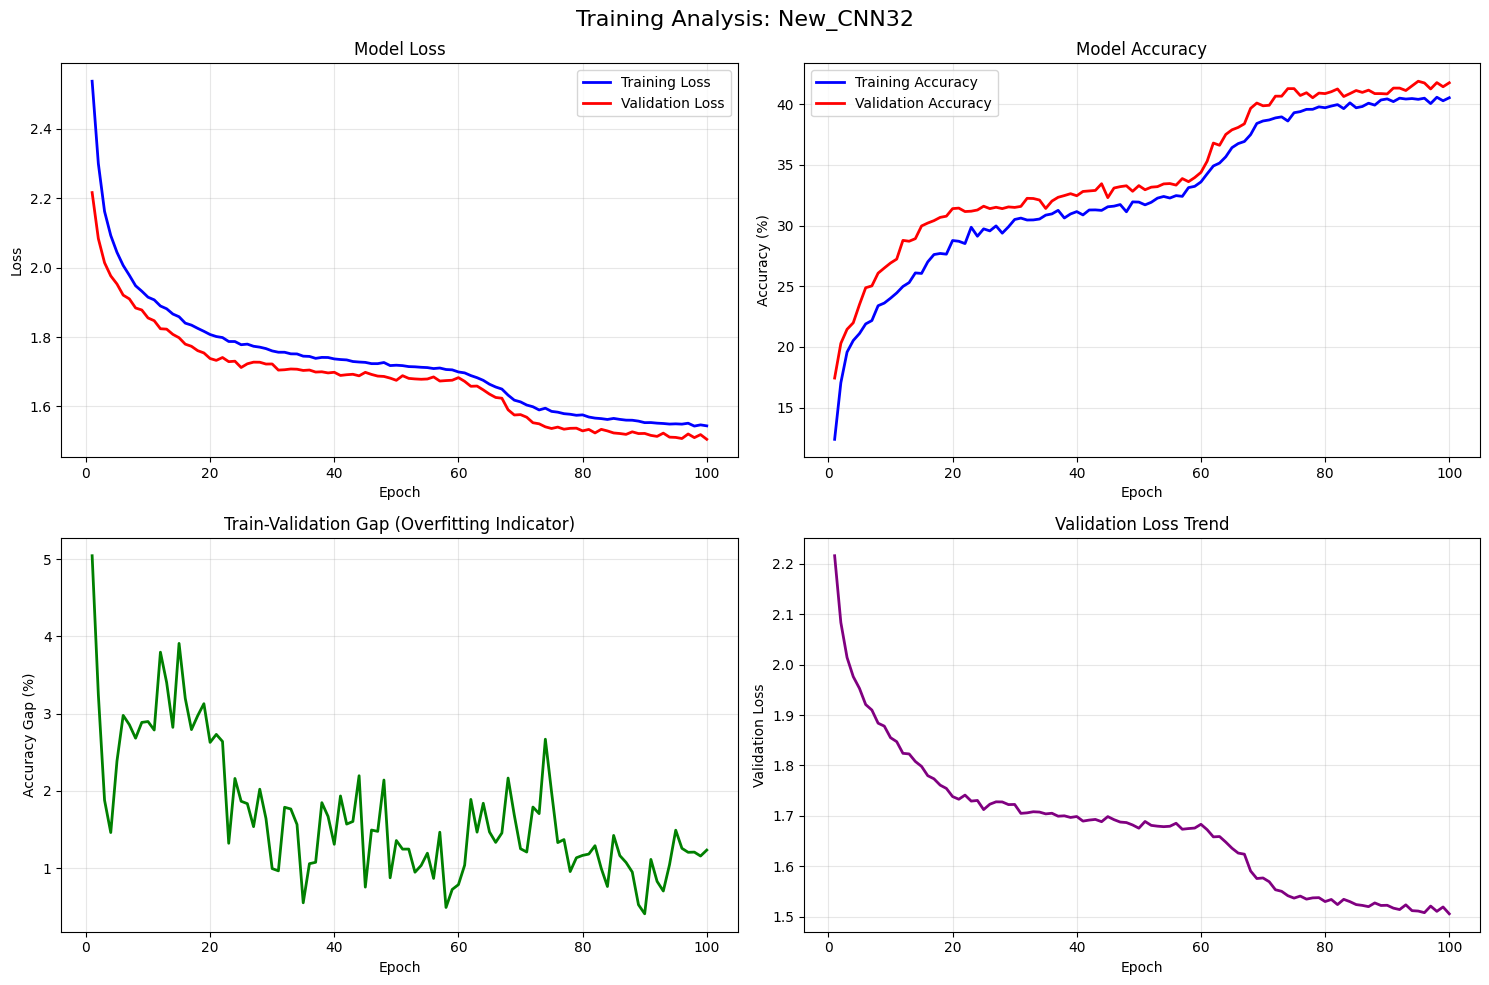


Training Summary for New_CNN32:
Epochs trained: 100
Final training accuracy: 40.52%
Final validation accuracy: 41.76%
Best validation accuracy: 41.76%

4. Testing model and generating analysis...
🔧 Applying I/Q swap fix to test dataset...
✅ I/Q channels corrected for real-world compatibility
Target modulations: ['OOK', '4ASK', '8ASK', 'BPSK', 'QPSK', '8PSK', '16PSK', '32PSK', '16QAM', '64QAM']
Target SNRs: [-20 -18 -16 -14 -12 -10  -8  -6  -4  -2   0   2   4   6   8  10  12  14
  16  18  20  22  24  26  28  30]
Test dataset size: 1015300


Testing model: 100%|█████████████████████████████████████████████| 7933/7933 [00:16<00:00, 483.09it/s, batch_acc=0.000]


Overall test accuracy: 33.5%
Modulation OOK: 101530 test samples
Modulation 4ASK: 101530 test samples
Modulation 8ASK: 101530 test samples
Modulation BPSK: 101530 test samples
Modulation QPSK: 101530 test samples
Modulation 8PSK: 101530 test samples
Modulation 16PSK: 101530 test samples
Modulation 32PSK: 101530 test samples
Modulation 16QAM: 101530 test samples
Modulation 64QAM: 101530 test samples


Calculating per-modulation accuracies: 100%|█████████████████████████| 10/10 [00:00<00:00, 18.26it/s, modulation=64QAM]


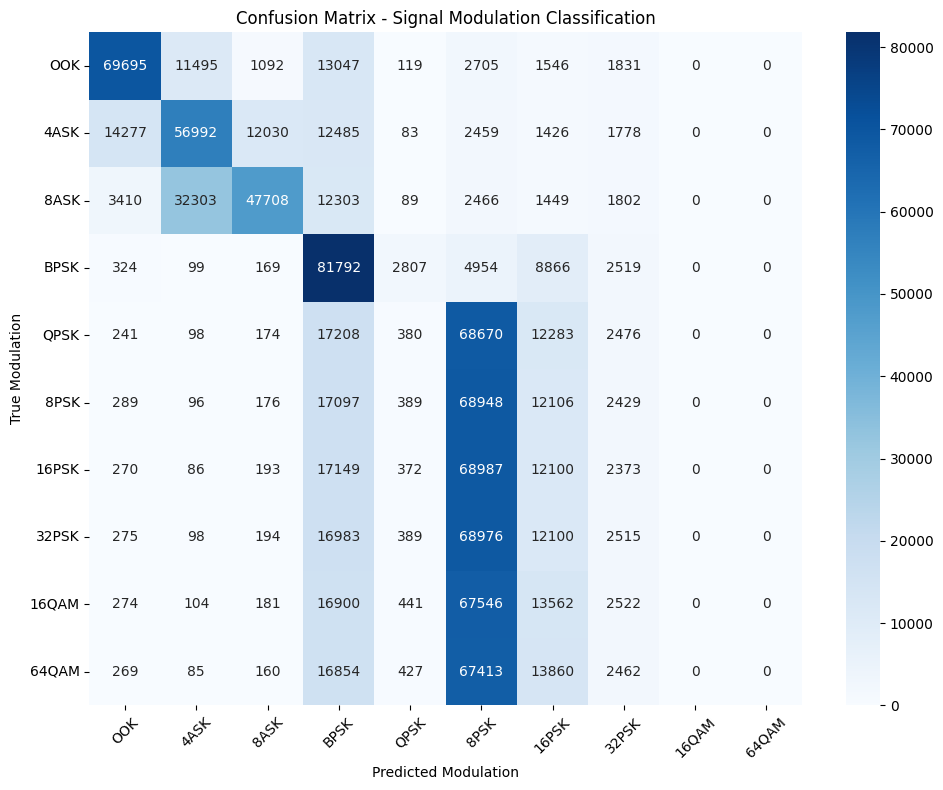


Detailed Classification Report:
              precision    recall  f1-score   support

         OOK       0.78      0.69      0.73    101530
        4ASK       0.56      0.56      0.56    101530
        8ASK       0.77      0.47      0.58    101530
        BPSK       0.37      0.81      0.51    101530
        QPSK       0.07      0.00      0.01    101530
        8PSK       0.16      0.68      0.26    101530
       16PSK       0.14      0.12      0.13    101530
       32PSK       0.11      0.02      0.04    101530
       16QAM       0.00      0.00      0.00    101530
       64QAM       0.00      0.00      0.00    101530

    accuracy                           0.34   1015300
   macro avg       0.30      0.34      0.28   1015300
weighted avg       0.30      0.34      0.28   1015300

Highlighting PSK modulations: ['BPSK', 'QPSK', '8PSK', '16PSK', '32PSK']


C:\Users\N208\.conda\envs\amc_env\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\N208\.conda\envs\amc_env\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\N208\.conda\envs\amc_env\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


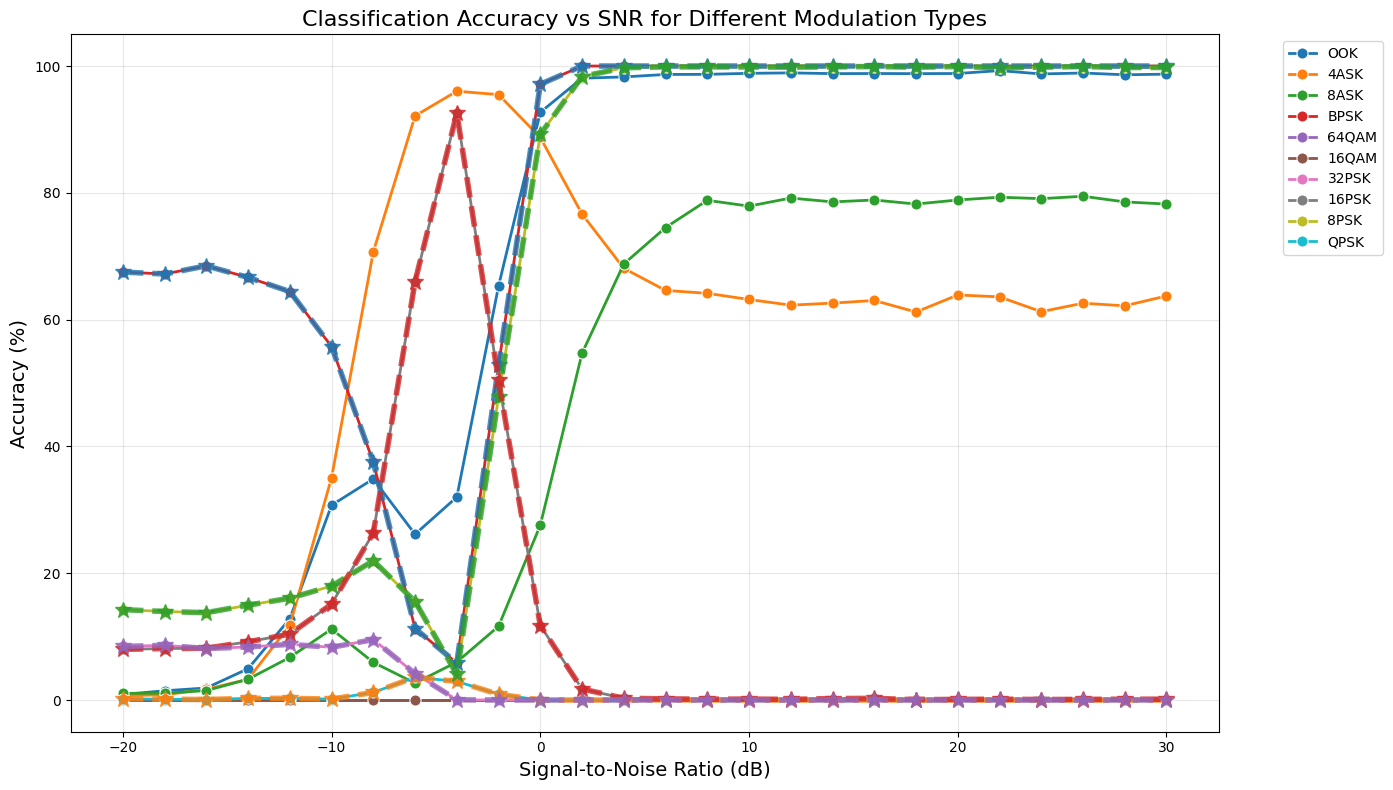

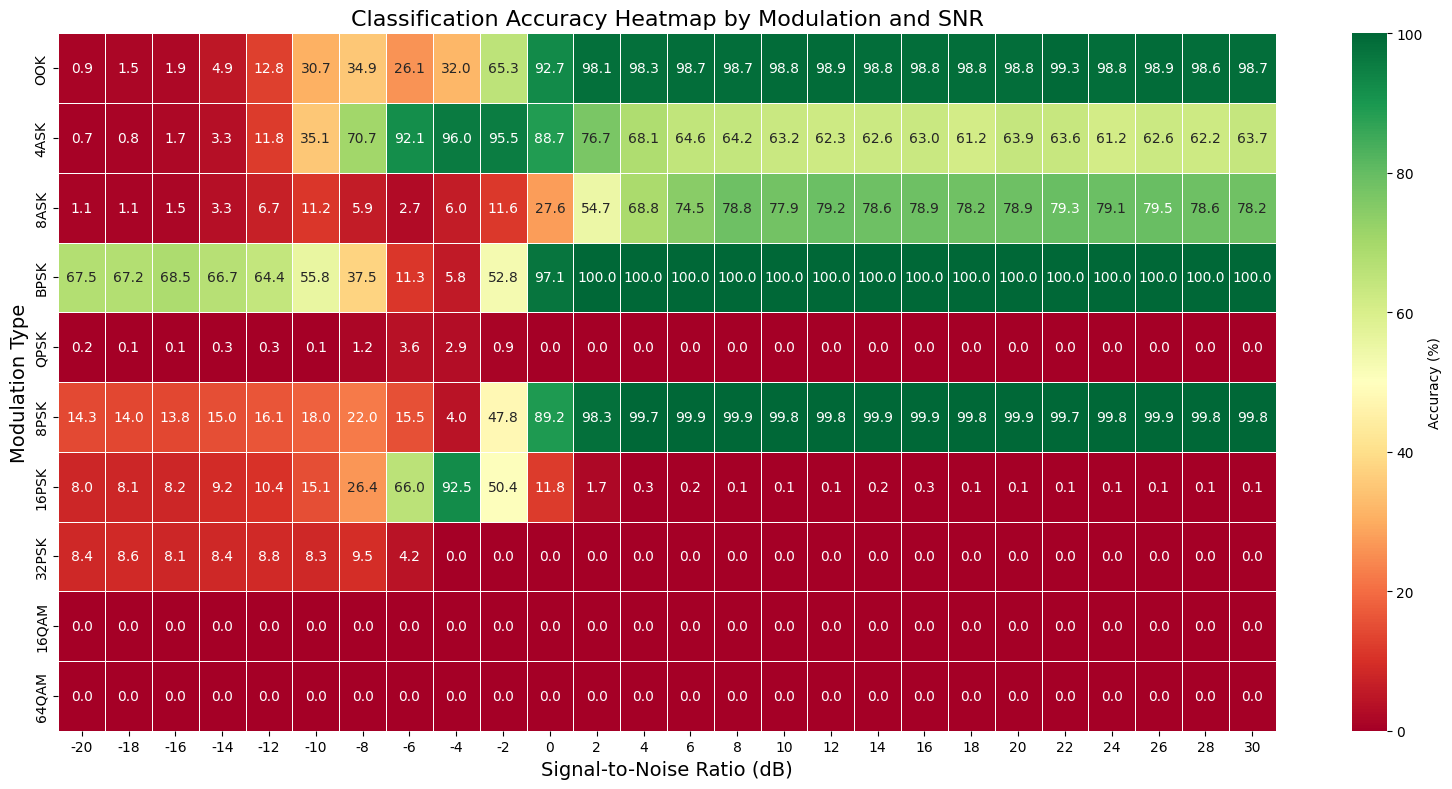


PERFORMANCE SUMMARY
Overall average accuracy: 33.50%

Best performing modulation: BPSK (80.56%)
Worst performing modulation: 64QAM (0.00%)

5. Analysis complete!


(New_CNN32(
   (features): Sequential(
     (0): Conv1d(2, 16, kernel_size=(9,), stride=(2,), padding=(4,))
     (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU(inplace=True)
     (3): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
     (4): Dropout(p=0.12, inplace=False)
     (5): Conv1d(16, 32, kernel_size=(7,), stride=(2,), padding=(3,))
     (6): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (7): ReLU(inplace=True)
     (8): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
     (9): Dropout(p=0.16000000000000003, inplace=False)
     (10): Conv1d(32, 32, kernel_size=(5,), stride=(2,), padding=(2,))
     (11): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (12): ReLU(inplace=True)
     (13): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
     (14): Dropout(p=0.16000000000000003, inplace=False)
     (15): Conv1d(32, 24, kernel_size=(3,)

In [76]:
improved_train_test_plots(
    model=New_CNN32(n_labels=10),
    model_name='New_CNN32',
    device='cuda',
    verbose= True,
    num_epoch=100 

)

TRAINING AND EVALUATION PIPELINE: New_CNN64

1. Analyzing dataset distribution...
🔧 Applying I/Q swap fix to test dataset...
✅ I/Q channels corrected for real-world compatibility


Analyzing test dataset: 100%|███████████████████| 820144/820144 [00:04<00:00, 190292.68it/s, current_mod=32PSK, snr=30]



TEST Dataset Distribution Analysis:
Total samples: 820,144

Modulation distribution:
  OOK: 102,518 samples (12.5%)
  4ASK: 102,518 samples (12.5%)
  8ASK: 102,518 samples (12.5%)
  BPSK: 102,518 samples (12.5%)
  QPSK: 102,518 samples (12.5%)
  8PSK: 102,518 samples (12.5%)
  16PSK: 102,518 samples (12.5%)
  32PSK: 102,518 samples (12.5%)

Dataset balance: Perfectly balanced

2. Training New_CNN64...
GPU: NVIDIA GeForce RTX 5070 Ti
Initial GPU memory: 0.04GB / 0.06GB


Training:   0%|                                                                                | 0/100 [00:01<?, ?it/s]

Epoch 001 | Train Loss: 2.2802, Acc: 0.1389
            | Val   Loss: 1.9902, Acc: 0.1857
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB


Training:   2%|█▍                                                                      | 2/100 [00:02<01:47,  1.09s/it]

Epoch 002 | Train Loss: 2.0769, Acc: 0.1809
            | Val   Loss: 1.9296, Acc: 0.2089
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB


Training:   3%|██▏                                                                     | 3/100 [00:03<01:33,  1.04it/s]

Epoch 003 | Train Loss: 2.0038, Acc: 0.1977
            | Val   Loss: 1.9163, Acc: 0.2186
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB


Training:   4%|██▉                                                                     | 4/100 [00:03<01:29,  1.08it/s]

Epoch 004 | Train Loss: 1.9513, Acc: 0.2106
            | Val   Loss: 1.9367, Acc: 0.2234
            | LR: 0.000100, Patience: 1/20
            | GPU Memory: 0.04GB
            | *** New best validation accuracy! ***


Training:   5%|███▌                                                                    | 5/100 [00:04<01:26,  1.10it/s]

Epoch 005 | Train Loss: 1.9093, Acc: 0.2181
            | Val   Loss: 1.9406, Acc: 0.2281
            | LR: 0.000100, Patience: 2/20
            | GPU Memory: 0.04GB
            | *** New best validation accuracy! ***


Training:   6%|████▎                                                                   | 6/100 [00:05<01:27,  1.07it/s]

Epoch 006 | Train Loss: 1.8772, Acc: 0.2230
            | Val   Loss: 1.9276, Acc: 0.2459
            | LR: 0.000100, Patience: 3/20
            | GPU Memory: 0.04GB
            | *** New best validation accuracy! ***


Training:   7%|█████                                                                   | 7/100 [00:06<01:25,  1.08it/s]

Epoch 007 | Train Loss: 1.8562, Acc: 0.2288
            | Val   Loss: 1.9047, Acc: 0.2606
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB


Training:   8%|█████▊                                                                  | 8/100 [00:07<01:23,  1.10it/s]

Epoch 008 | Train Loss: 1.8399, Acc: 0.2312
            | Val   Loss: 1.8962, Acc: 0.2709
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB


Training:   9%|██████▍                                                                 | 9/100 [00:08<01:24,  1.07it/s]

Epoch 009 | Train Loss: 1.8237, Acc: 0.2403
            | Val   Loss: 1.8672, Acc: 0.2796
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB


Training:  10%|███████                                                                | 10/100 [00:09<01:25,  1.05it/s]

Epoch 010 | Train Loss: 1.8107, Acc: 0.2429
            | Val   Loss: 1.8739, Acc: 0.2759
            | LR: 0.000100, Patience: 1/20
            | GPU Memory: 0.04GB
GPU memory after cleanup: 0.04GB


Training:  11%|███████▊                                                               | 11/100 [00:10<01:32,  1.04s/it]

Epoch 011 | Train Loss: 1.8038, Acc: 0.2424
            | Val   Loss: 1.8573, Acc: 0.2873
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB


Training:  12%|████████▌                                                              | 12/100 [00:11<01:33,  1.06s/it]

Epoch 012 | Train Loss: 1.7974, Acc: 0.2550
            | Val   Loss: 1.8337, Acc: 0.2858
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB


Training:  13%|█████████▏                                                             | 13/100 [00:12<01:31,  1.05s/it]

Epoch 013 | Train Loss: 1.7829, Acc: 0.2568
            | Val   Loss: 1.8079, Acc: 0.2952
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB


Training:  14%|█████████▉                                                             | 14/100 [00:13<01:28,  1.03s/it]

Epoch 014 | Train Loss: 1.7734, Acc: 0.2639
            | Val   Loss: 1.7945, Acc: 0.3029
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB


Training:  15%|██████████▋                                                            | 15/100 [00:14<01:26,  1.02s/it]

Epoch 015 | Train Loss: 1.7667, Acc: 0.2649
            | Val   Loss: 1.7770, Acc: 0.3057
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB


Training:  17%|████████████                                                           | 17/100 [00:17<01:26,  1.04s/it]

Epoch 017 | Train Loss: 1.7473, Acc: 0.2738
            | Val   Loss: 1.7507, Acc: 0.3053
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB


Training:  18%|████████████▊                                                          | 18/100 [00:18<01:25,  1.05s/it]

Epoch 018 | Train Loss: 1.7421, Acc: 0.2847
            | Val   Loss: 1.7350, Acc: 0.3100
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB


Training:  20%|██████████████▏                                                        | 20/100 [00:20<01:24,  1.05s/it]

Epoch 020 | Train Loss: 1.7219, Acc: 0.2908
            | Val   Loss: 1.7280, Acc: 0.3044
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB
GPU memory after cleanup: 0.04GB


Training:  23%|████████████████▎                                                      | 23/100 [00:23<01:23,  1.09s/it]

Epoch 023 | Train Loss: 1.7089, Acc: 0.2956
            | Val   Loss: 1.6977, Acc: 0.3097
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB


Training:  24%|█████████████████                                                      | 24/100 [00:24<01:20,  1.06s/it]

Epoch 024 | Train Loss: 1.7033, Acc: 0.3020
            | Val   Loss: 1.7014, Acc: 0.3141
            | LR: 0.000100, Patience: 1/20
            | GPU Memory: 0.04GB
            | *** New best validation accuracy! ***


Training:  25%|█████████████████▊                                                     | 25/100 [00:25<01:18,  1.04s/it]

Epoch 025 | Train Loss: 1.6974, Acc: 0.2984
            | Val   Loss: 1.6920, Acc: 0.3126
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB


Training:  27%|███████████████████▏                                                   | 27/100 [00:27<01:16,  1.05s/it]

Epoch 027 | Train Loss: 1.6940, Acc: 0.3068
            | Val   Loss: 1.6886, Acc: 0.3135
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB


Training:  30%|█████████████████████▎                                                 | 30/100 [00:30<01:11,  1.03s/it]

Epoch 030 | Train Loss: 1.6846, Acc: 0.3080
            | Val   Loss: 1.6754, Acc: 0.3166
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB
GPU memory after cleanup: 0.04GB


Training:  34%|████████████████████████▏                                              | 34/100 [00:35<01:10,  1.08s/it]

Epoch 034 | Train Loss: 1.6785, Acc: 0.3117
            | Val   Loss: 1.6705, Acc: 0.3135
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB


Training:  36%|█████████████████████████▌                                             | 36/100 [00:37<01:11,  1.12s/it]

Epoch 036 | Train Loss: 1.6700, Acc: 0.3156
            | Val   Loss: 1.6530, Acc: 0.3176
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB


Training:  37%|██████████████████████████▎                                            | 37/100 [00:38<01:06,  1.05s/it]

Epoch 037 | Train Loss: 1.6672, Acc: 0.3202
            | Val   Loss: 1.6595, Acc: 0.3186
            | LR: 0.000100, Patience: 1/20
            | GPU Memory: 0.04GB
            | *** New best validation accuracy! ***


Training:  38%|██████████████████████████▉                                            | 38/100 [00:39<01:01,  1.01it/s]

Epoch 038 | Train Loss: 1.6667, Acc: 0.3200
            | Val   Loss: 1.6605, Acc: 0.3232
            | LR: 0.000100, Patience: 2/20
            | GPU Memory: 0.04GB
            | *** New best validation accuracy! ***


Training:  39%|███████████████████████████▋                                           | 39/100 [00:40<00:58,  1.04it/s]

Epoch 039 | Train Loss: 1.6638, Acc: 0.3216
            | Val   Loss: 1.6394, Acc: 0.3341
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB


Training:  40%|████████████████████████████▍                                          | 40/100 [00:41<00:56,  1.05it/s]

Epoch 040 | Train Loss: 1.6561, Acc: 0.3273
            | Val   Loss: 1.6419, Acc: 0.3392
            | LR: 0.000100, Patience: 1/20
            | GPU Memory: 0.04GB
            | *** New best validation accuracy! ***
GPU memory after cleanup: 0.04GB


Training:  41%|█████████████████████████████                                          | 41/100 [00:42<00:59,  1.00s/it]

Epoch 041 | Train Loss: 1.6522, Acc: 0.3332
            | Val   Loss: 1.6447, Acc: 0.3404
            | LR: 0.000100, Patience: 2/20
            | GPU Memory: 0.04GB
            | *** New best validation accuracy! ***


Training:  42%|█████████████████████████████▊                                         | 42/100 [00:43<00:56,  1.02it/s]

Epoch 042 | Train Loss: 1.6463, Acc: 0.3374
            | Val   Loss: 1.6195, Acc: 0.3563
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB


Training:  43%|██████████████████████████████▌                                        | 43/100 [00:44<00:54,  1.04it/s]

Epoch 043 | Train Loss: 1.6303, Acc: 0.3523
            | Val   Loss: 1.6250, Acc: 0.3596
            | LR: 0.000100, Patience: 1/20
            | GPU Memory: 0.04GB
            | *** New best validation accuracy! ***


Training:  44%|███████████████████████████████▏                                       | 44/100 [00:45<00:53,  1.05it/s]

Epoch 044 | Train Loss: 1.6130, Acc: 0.3661
            | Val   Loss: 1.5923, Acc: 0.3777
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB


Training:  45%|███████████████████████████████▉                                       | 45/100 [00:45<00:51,  1.06it/s]

Epoch 045 | Train Loss: 1.5890, Acc: 0.3752
            | Val   Loss: 1.5652, Acc: 0.3838
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB


Training:  46%|████████████████████████████████▋                                      | 46/100 [00:46<00:51,  1.05it/s]

Epoch 046 | Train Loss: 1.5663, Acc: 0.3849
            | Val   Loss: 1.5490, Acc: 0.3884
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB


Training:  47%|█████████████████████████████████▎                                     | 47/100 [00:47<00:49,  1.07it/s]

Epoch 047 | Train Loss: 1.5571, Acc: 0.3882
            | Val   Loss: 1.5253, Acc: 0.3997
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB


Training:  48%|██████████████████████████████████                                     | 48/100 [00:48<00:47,  1.10it/s]

Epoch 048 | Train Loss: 1.5495, Acc: 0.3886
            | Val   Loss: 1.5196, Acc: 0.3971
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB


Training:  49%|██████████████████████████████████▊                                    | 49/100 [00:49<00:45,  1.12it/s]

Epoch 049 | Train Loss: 1.5438, Acc: 0.3891
            | Val   Loss: 1.5182, Acc: 0.3951
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB


Training:  50%|███████████████████████████████████▌                                   | 50/100 [00:50<00:43,  1.14it/s]

Epoch 050 | Train Loss: 1.5367, Acc: 0.3928
            | Val   Loss: 1.5088, Acc: 0.4016
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB
GPU memory after cleanup: 0.04GB


Training:  51%|████████████████████████████████████▏                                  | 51/100 [00:51<00:45,  1.07it/s]

Epoch 051 | Train Loss: 1.5342, Acc: 0.3924
            | Val   Loss: 1.5044, Acc: 0.4026
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB


Training:  52%|████████████████████████████████████▉                                  | 52/100 [00:52<00:44,  1.09it/s]

Epoch 052 | Train Loss: 1.5277, Acc: 0.4000
            | Val   Loss: 1.4909, Acc: 0.4068
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB


Training:  55%|███████████████████████████████████████                                | 55/100 [00:55<00:40,  1.10it/s]

Epoch 055 | Train Loss: 1.5192, Acc: 0.3976
            | Val   Loss: 1.4760, Acc: 0.4125
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB


Training:  57%|████████████████████████████████████████▍                              | 57/100 [00:56<00:40,  1.06it/s]

Epoch 057 | Train Loss: 1.5162, Acc: 0.4007
            | Val   Loss: 1.4723, Acc: 0.4154
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB


Training:  59%|█████████████████████████████████████████▉                             | 59/100 [00:58<00:37,  1.09it/s]

Epoch 059 | Train Loss: 1.5083, Acc: 0.4055
            | Val   Loss: 1.4646, Acc: 0.4176
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB


Training:  60%|██████████████████████████████████████████▌                            | 60/100 [00:59<00:36,  1.10it/s]

Epoch 060 | Train Loss: 1.5062, Acc: 0.4053
            | Val   Loss: 1.4764, Acc: 0.4099
            | LR: 0.000100, Patience: 1/20
            | GPU Memory: 0.04GB
GPU memory after cleanup: 0.04GB


Training:  64%|█████████████████████████████████████████████▍                         | 64/100 [01:03<00:32,  1.11it/s]

Epoch 064 | Train Loss: 1.5019, Acc: 0.4078
            | Val   Loss: 1.4610, Acc: 0.4194
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB


Training:  66%|██████████████████████████████████████████████▊                        | 66/100 [01:05<00:31,  1.09it/s]

Epoch 066 | Train Loss: 1.4982, Acc: 0.4077
            | Val   Loss: 1.4505, Acc: 0.4229
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB


Training:  70%|█████████████████████████████████████████████████▋                     | 70/100 [01:08<00:27,  1.08it/s]

Epoch 070 | Train Loss: 1.4906, Acc: 0.4114
            | Val   Loss: 1.4669, Acc: 0.4133
            | LR: 0.000100, Patience: 4/20
            | GPU Memory: 0.04GB
GPU memory after cleanup: 0.04GB


Training:  71%|██████████████████████████████████████████████████▍                    | 71/100 [01:10<00:29,  1.01s/it]

Epoch 071 | Train Loss: 1.4887, Acc: 0.4110
            | Val   Loss: 1.4468, Acc: 0.4235
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB


Training:  74%|████████████████████████████████████████████████████▌                  | 74/100 [01:13<00:26,  1.01s/it]

Epoch 074 | Train Loss: 1.4872, Acc: 0.4092
            | Val   Loss: 1.4382, Acc: 0.4286
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB


Training:  78%|███████████████████████████████████████████████████████▍               | 78/100 [01:17<00:22,  1.03s/it]

Epoch 078 | Train Loss: 1.4831, Acc: 0.4150
            | Val   Loss: 1.4369, Acc: 0.4299
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB


Training:  80%|████████████████████████████████████████████████████████▊              | 80/100 [01:19<00:20,  1.04s/it]

Epoch 080 | Train Loss: 1.4775, Acc: 0.4191
            | Val   Loss: 1.4439, Acc: 0.4252
            | LR: 0.000100, Patience: 2/20
            | GPU Memory: 0.04GB
GPU memory after cleanup: 0.04GB


Training:  81%|█████████████████████████████████████████████████████████▌             | 81/100 [01:20<00:21,  1.11s/it]

Epoch 081 | Train Loss: 1.4773, Acc: 0.4169
            | Val   Loss: 1.4334, Acc: 0.4317
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB


Training:  82%|██████████████████████████████████████████████████████████▏            | 82/100 [01:21<00:19,  1.07s/it]

Epoch 082 | Train Loss: 1.4780, Acc: 0.4124
            | Val   Loss: 1.4307, Acc: 0.4310
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB


Training:  88%|██████████████████████████████████████████████████████████████▍        | 88/100 [01:27<00:12,  1.02s/it]

Epoch 088 | Train Loss: 1.4692, Acc: 0.4216
            | Val   Loss: 1.4275, Acc: 0.4345
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB


Training:  90%|███████████████████████████████████████████████████████████████▉       | 90/100 [01:29<00:10,  1.02s/it]

Epoch 090 | Train Loss: 1.4709, Acc: 0.4198
            | Val   Loss: 1.4254, Acc: 0.4342
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB
GPU memory after cleanup: 0.04GB


Training:  95%|███████████████████████████████████████████████████████████████████▍   | 95/100 [01:35<00:05,  1.05s/it]

Epoch 095 | Train Loss: 1.4672, Acc: 0.4216
            | Val   Loss: 1.4182, Acc: 0.4365
            | LR: 0.000100, Patience: 0/20
            | GPU Memory: 0.04GB


Training: 100%|██████████████████████████████████████████████████████████████████████| 100/100 [01:39<00:00,  1.00it/s]


Epoch 100 | Train Loss: 1.4614, Acc: 0.4226
            | Val   Loss: 1.4238, Acc: 0.4369
            | LR: 0.000100, Patience: 5/20
            | GPU Memory: 0.04GB
            | *** New best validation accuracy! ***

Training completed!
Epochs trained: 100
Final validation accuracy: 0.4369
Best validation accuracy: 0.4365
Final GPU memory: 0.04GB
Model saved as:
  - C:\workarea\CNN model\model\New_CNN64_state_dict.pth
  - C:\workarea\CNN model\model\New_CNN64_full_model.pth

3. Plotting training history...


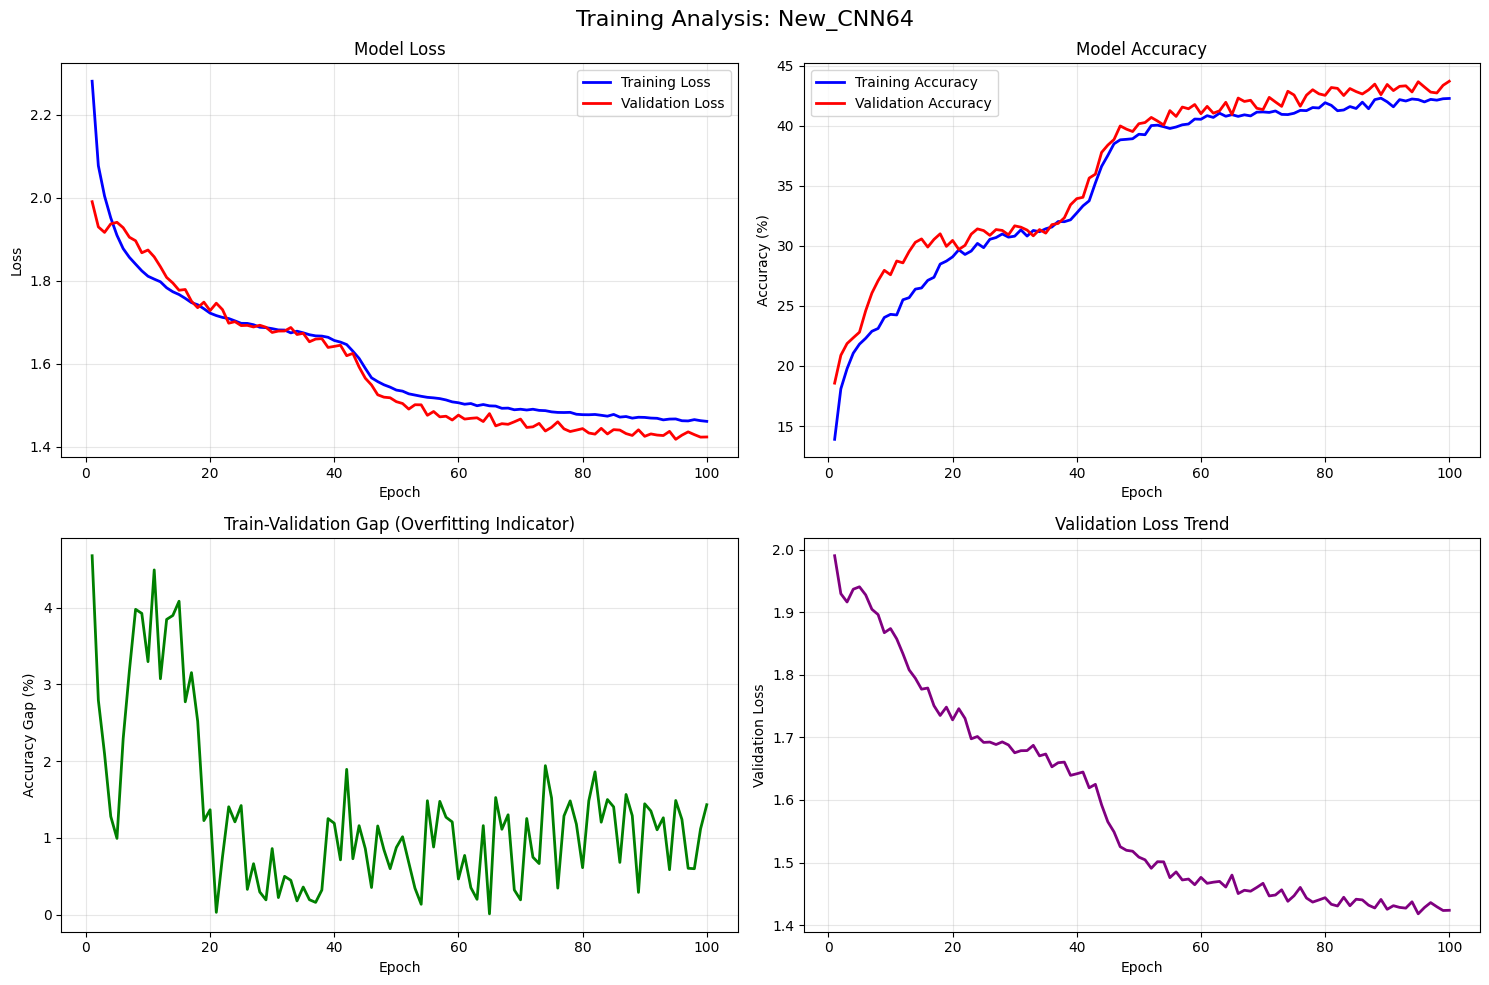


Training Summary for New_CNN64:
Epochs trained: 100
Final training accuracy: 42.26%
Final validation accuracy: 43.69%
Best validation accuracy: 43.65%

4. Testing model and generating analysis...
🔧 Applying I/Q swap fix to test dataset...
✅ I/Q channels corrected for real-world compatibility
Target modulations: ['OOK', '4ASK', '8ASK', 'BPSK', 'QPSK', '8PSK', '16PSK', '32PSK']
Target SNRs: [-20 -18 -16 -14 -12 -10  -8  -6  -4  -2   0   2   4   6   8  10  12  14
  16  18  20  22  24  26  28  30]
Test dataset size: 820144


Testing model: 100%|█████████████████████████████████████████████| 6408/6408 [00:16<00:00, 387.72it/s, batch_acc=0.000]


Overall test accuracy: 43.09%
Modulation OOK: 102518 test samples
Modulation 4ASK: 102518 test samples
Modulation 8ASK: 102518 test samples
Modulation BPSK: 102518 test samples
Modulation QPSK: 102518 test samples
Modulation 8PSK: 102518 test samples
Modulation 16PSK: 102518 test samples
Modulation 32PSK: 102518 test samples


Calculating per-modulation accuracies: 100%|███████████████████████████| 8/8 [00:00<00:00, 24.06it/s, modulation=32PSK]


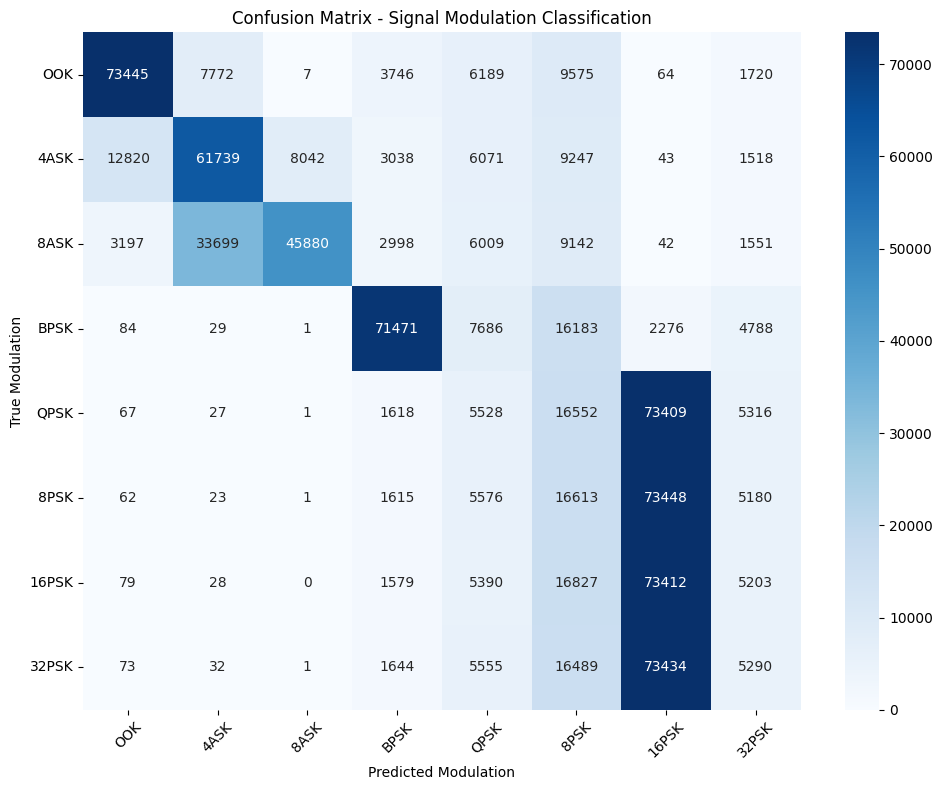


Detailed Classification Report:
              precision    recall  f1-score   support

         OOK       0.82      0.72      0.76    102518
        4ASK       0.60      0.60      0.60    102518
        8ASK       0.85      0.45      0.59    102518
        BPSK       0.81      0.70      0.75    102518
        QPSK       0.12      0.05      0.07    102518
        8PSK       0.15      0.16      0.16    102518
       16PSK       0.25      0.72      0.37    102518
       32PSK       0.17      0.05      0.08    102518

    accuracy                           0.43    820144
   macro avg       0.47      0.43      0.42    820144
weighted avg       0.47      0.43      0.42    820144

Highlighting PSK modulations: ['BPSK', 'QPSK', '8PSK', '16PSK', '32PSK']


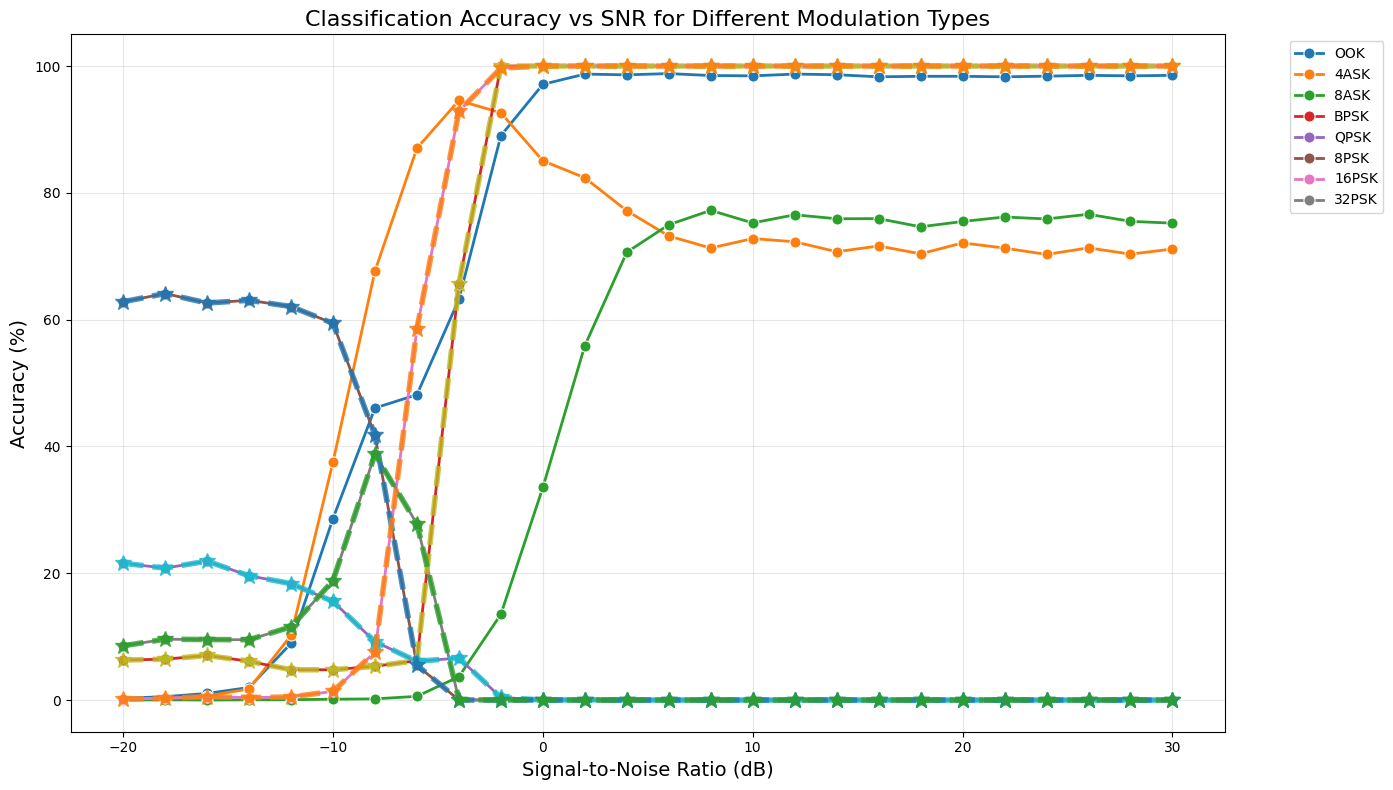

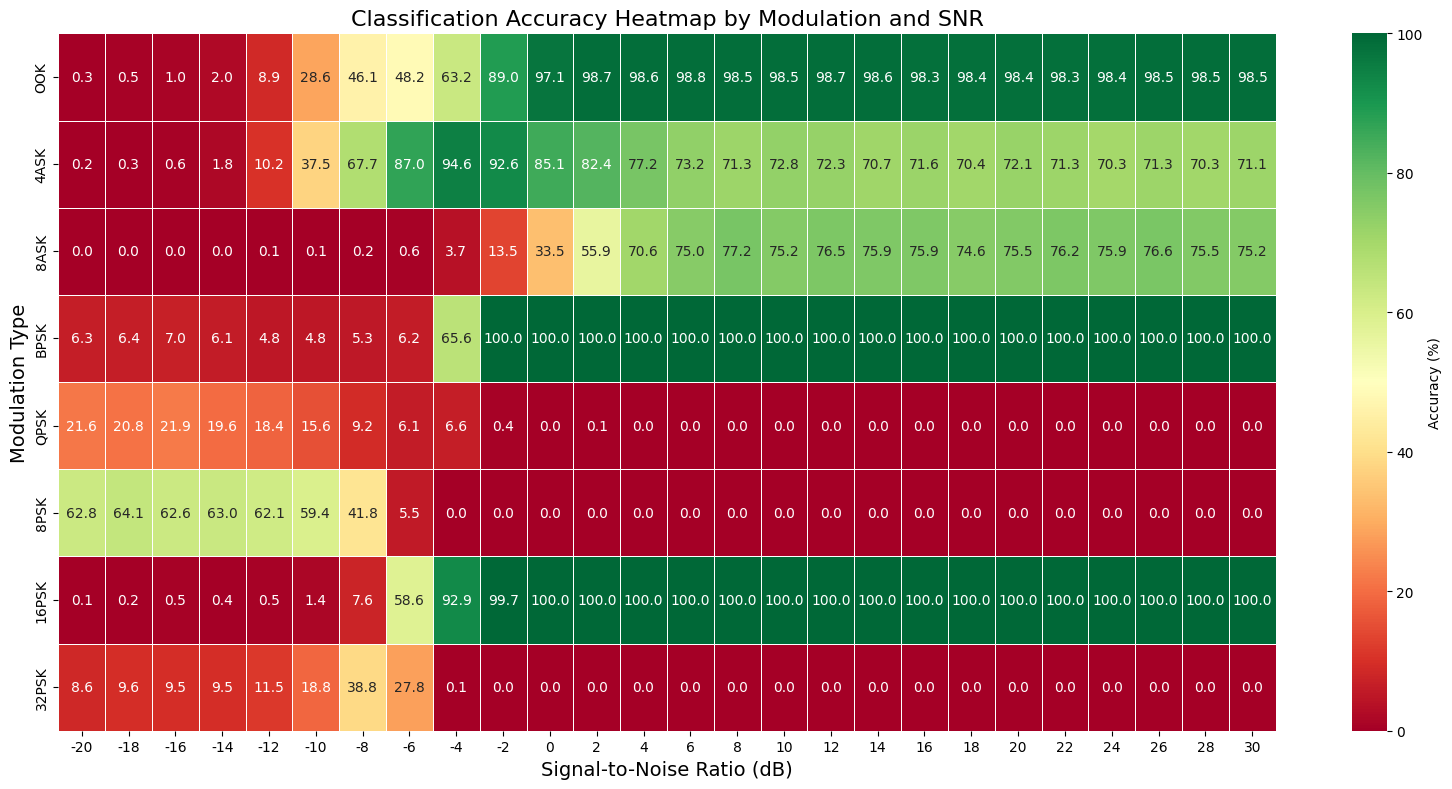


PERFORMANCE SUMMARY
Overall average accuracy: 43.09%

Best performing modulation: OOK (71.64%)
Worst performing modulation: 32PSK (5.16%)

5. Analysis complete!


(New_CNN64(
   (features): Sequential(
     (0): Conv1d(2, 32, kernel_size=(9,), stride=(2,), padding=(4,))
     (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU(inplace=True)
     (3): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
     (4): Dropout(p=0.15, inplace=False)
     (5): Conv1d(32, 64, kernel_size=(7,), stride=(2,), padding=(3,))
     (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (7): ReLU(inplace=True)
     (8): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
     (9): Dropout(p=0.2, inplace=False)
     (10): Conv1d(64, 64, kernel_size=(5,), stride=(2,), padding=(2,))
     (11): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (12): ReLU(inplace=True)
     (13): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
     (14): Dropout(p=0.25, inplace=False)
     (15): Conv1d(64, 48, kernel_size=(3,), stride=(1,), padding=(1,))
  

In [73]:
improved_train_test_plots(
    model=New_CNN64(n_labels=10),
    model_name='New_CNN64',
    device='cuda',
    verbose= True,
    num_epoch=100 

)